In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import re
import nltk
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time 


### Importing of Kaggle Repository Twitter Dataset

In this Classification Task, we are trying to train a model to classify our crawled dataset whether the tweets are subjective or objective, positive or negative sentiments

In [2]:
df_tweet = pd.read_csv("Tweet.csv")

In [3]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [4]:
df_tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [5]:
df_company_tweet = pd.read_csv("Company_Tweet.csv")

In [6]:
df_company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
df_company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [8]:
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [9]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


### Importing of Crawled Twitter Dataset

This is the crawled dataset from twitter with regards to stocks such as AAPL, AMZN, MSFT, TSLA, GOOGL

In [10]:
aapl_df = pd.read_csv("AAPL.csv")
amzn_df = pd.read_csv("AMZN.csv")
msft_df = pd.read_csv("MSFT.csv")
tsla_df = pd.read_csv("TSLA.csv")
googl_df = pd.read_csv("GOOGL.csv")

In [11]:
aapl_df["ticker_symbol"] = "AAPL"
amzn_df["ticker_symbol"] = "AMZN"
msft_df["ticker_symbol"] = "MSFT"
tsla_df["ticker_symbol"] = "TSLA"
googl_df["ticker_symbol"] = "GOOGL"

In [12]:
crawled_tweets = pd.concat([aapl_df, amzn_df, msft_df, tsla_df, googl_df], axis = 0)

In [13]:
crawled_tweets.reset_index(drop = True, inplace= True)


In [14]:
crawled_tweets.tail()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol
7373,2023-02-28 04:39:48+00:00,1630427525334564871,ProfitsTaken,⚡️ Youtube video up and live for 2.27.2023! \n...,32,2,8,GOOGL
7374,2023-02-28 02:20:32+00:00,1630392478833451008,FIREDUpWealth,DoJ accuses Google of deleting chats in its an...,11,0,1,GOOGL
7375,2023-02-28 02:19:17+00:00,1630392162876637184,FIREDUpWealth,#Waymo to test driverless rides with employees...,14,2,1,GOOGL
7376,2023-02-28 01:56:07+00:00,1630386331087151106,data168,Not sure if anyone uses YouTube to listen to m...,39,14,0,GOOGL
7377,2023-02-28 00:53:53+00:00,1630370673175699457,tomthetrader1,Google was firmly rejected and is now approach...,30,2,5,GOOGL


In [15]:
def datasetInfo(dataset):
    print(f" Dataset Information and type \n {dataset.info()}")
    print("--------------------------------------------------------\n\n Data Types: ")
    print(dataset.dtypes)
    print("--------------------------------------------------------\n\n Rows and Columns: ")
    print(dataset.shape)
    print("--------------------------------------------------------\n\n Column Names: ")
    print(dataset.columns)
    print("--------------------------------------------------------\n\n Null Values: ")
    print(dataset.apply(lambda x: sum(x.isnull()) / len(dataset)))
    print("--------------------------------------------------------\n\n Unique Values: ")
    print(dataset.nunique())
    print("--------------------------------------------------------\n\n Describe: ")
    print(dataset.describe())

In [16]:
datasetInfo(tweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
dtypes: int64(5), object(3)
memory usage: 297.8+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id          int64
ticker_symbol    object
writer           object
post_date         int64
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(4336445, 8)
--------------------------------------------------------

 Column Names: 
Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num

In [17]:
datasetInfo(crawled_tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7378 entries, 0 to 7377
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           7378 non-null   object
 1   id             7378 non-null   int64 
 2   user           7378 non-null   object
 3   tweet          7378 non-null   object
 4   likes          7378 non-null   int64 
 5   replies        7378 non-null   int64 
 6   retweets       7378 non-null   int64 
 7   ticker_symbol  7378 non-null   object
dtypes: int64(4), object(4)
memory usage: 461.2+ KB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
date             object
id                int64
user             object
tweet            object
likes             int64
replies           int64
retweets          int64
ticker_symbol    object
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(7378, 8)
---------

After Merging Remove the dataframes that columns are empty

In [18]:
tweets.dropna(inplace = True)

In [19]:
crawled_tweets.dropna(inplace = True)

Convert our tweet date_time into just date

In [20]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets['post_date'] = tweets["post_date"].dt.date
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [21]:
crawled_tweets['date'] = pd.to_datetime(crawled_tweets['date'])
crawled_tweets['date'] = crawled_tweets['date'].dt.date

We need to differentiate active tweets which are more "Reputable" compared to botting tweets or spams. <br>
Activities can be defined as comments/replies, retweets, and likes.

In [22]:
tweets.sort_values(by = "comment_num" , ascending  = False, inplace = True)
tweets


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0
...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0


In [23]:
crawled_tweets.sort_values(by = "replies" , ascending  = False, inplace = True)
crawled_tweets

,date,id,user,tweet,likes,replies,retweets,ticker_symbol
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA
...,...,...,...,...,...,...,...,...
5049,2023-01-23,1617662159806410753,HeartDocTesla,Stocks rally. Default is MSM must create a neg...,9,0,1,TSLA
6348,2023-01-15,1614662694262407168,OptionsMike,$GOOGL remains a lagger in tech. 50D almost th...,10,0,3,GOOGL
6347,2023-01-15,1614676421208866818,TogetherWeTrad3,$GOOGL https://t.co/zpvbKIrA98,15,0,2,GOOGL
1298,2023-02-16,1626296950562619392,AhmedAbouhalawa,@thejefflutz @elonmusk @skorusARK We must shor...,37,0,0,AAPL


The tweet activities will be defined by the summation of all comments/replies, likes and retweets to differentiate from bots or spams, where tweets are more "usable" for sentimental analysis

In [24]:
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0,0


In [25]:
crawled_tweets["tweet_activity"] = crawled_tweets["replies"] + crawled_tweets["likes"] + crawled_tweets["retweets"]
crawled_tweets

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA,4930
...,...,...,...,...,...,...,...,...,...
5049,2023-01-23,1617662159806410753,HeartDocTesla,Stocks rally. Default is MSM must create a neg...,9,0,1,TSLA,10
6348,2023-01-15,1614662694262407168,OptionsMike,$GOOGL remains a lagger in tech. 50D almost th...,10,0,3,GOOGL,13
6347,2023-01-15,1614676421208866818,TogetherWeTrad3,$GOOGL https://t.co/zpvbKIrA98,15,0,2,GOOGL,17
1298,2023-02-16,1626296950562619392,AhmedAbouhalawa,@thejefflutz @elonmusk @skorusARK We must shor...,37,0,0,AAPL,37


### Filter Tweets that are >= 50 activities

In [26]:
filterTweets = tweets.loc[tweets["tweet_activity"] > 50]

In [27]:
filterCrawledTweets = crawled_tweets.loc[crawled_tweets["tweet_activity"] > 50]

In [28]:
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442


In [29]:
filterCrawledTweets.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA,4930


### Data Cleaning and Tokenization of text body

In [30]:
# Function to remove stopwords (common english stopwords from nltk)
from nltk.corpus import stopwords

def removeStopWords(df):
    finalList = []
    stop_words = set(stopwords.words('english'))
    for word in df:
        if word not in stop_words:
            finalList.append(word)
    df = finalList
    return df

In [31]:
# Function to stem tweets 
from nltk.stem.porter import *

def stem_text(text):
    
    stemmer = PorterStemmer()
   
    return [stemmer.stem(word) for word in text]

In [32]:
# Function to lemmatise tweets
def lemmatised_text(text):
    lemmatiser = nltk.stem.WordNetLemmatizer()
    return [lemmatiser.lemmatize(word) for word in text]

In [33]:
def clean_dataframe_text(df, column,lemma):
    
    # Define regex pattern to match URLs
    url_pattern = r"https?://\S+"
    
    # Remove URLs from text column
    df[column] = df[column].str.replace(url_pattern, "", regex=True)
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
    
    # Replace 's with 'is' or 'has'
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    # Remove not word characters
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
       
    # Remove digits 
    df[column] = df[column].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Convert the string in lower
    df[column] = df[column].str.lower()
    
    # Tokenised the words
    df[column]  = df[column].apply(lambda x : nltk.word_tokenize(x))

    # Remove stopwords from the NLTK stopword list
    df[column] = df[column].apply(lambda x : removeStopWords(x))
    
    if lemma:
    # lemmatised the text
        df[column] = df[column].apply(lambda x : lemmatised_text(x))
    else:
    # Stemmed the text
        df[column] = df[column].apply(lambda x : stem_text(x))
    #concatenate the tokenised list into string
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
      
    return df

In [34]:
# Tweets that are cleaned and lemmatised
filterTweetsLemma = clean_dataframe_text(filterTweets,"body",True)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:13: SettingWithCopyWa

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk goin...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month gas ten year take saving put ...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla feature request threadfeel free reply il...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versus sell whatever fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basically financially insane buy anythin...,442,0,0,442


In [35]:
# Tweets that are cleaned and stemmed
filterTweets = clean_dataframe_text(filterTweets,"body",False)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:13: SettingWithCopyWa

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442


In [36]:
filterTweets["body"].head()

3786974    id like point right right moment elonmusk go f...
4112626    tesla save month ga ten year take save put bal...
4306536    tesla featur request threadfeel free repli ill...
2823018           sell book versu sell whatev fuck want amzn
4182686    think basic financi insan buy anyth except ele...
Name: body, dtype: object

In [37]:
filterCrawledTweetsLemma = clean_dataframe_text(filterCrawledTweets, "tweet", True)
filterCrawledTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:13: SettingWithCopyWa

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit gas station leave everyday f...,4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voice feel huge asse...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardware never able drive arou...,3768,731,431,TSLA,4930


In [38]:
filterCrawledTweets= clean_dataframe_text(filterCrawledTweets, "tweet", False)
filterCrawledTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\4015562605.py:13: SettingWithCopyWa

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930


### Tweet EDA

In [39]:
filterTweets["writer"].describe()


count           41625
unique           2797
top       TESLAcharts
freq             2212
Name: writer, dtype: object

In [40]:
filterCrawledTweets["user"].describe()

count             2137
unique             648
top       StockMKTNewz
freq               109
Name: user, dtype: object

### Writer Data Exploration

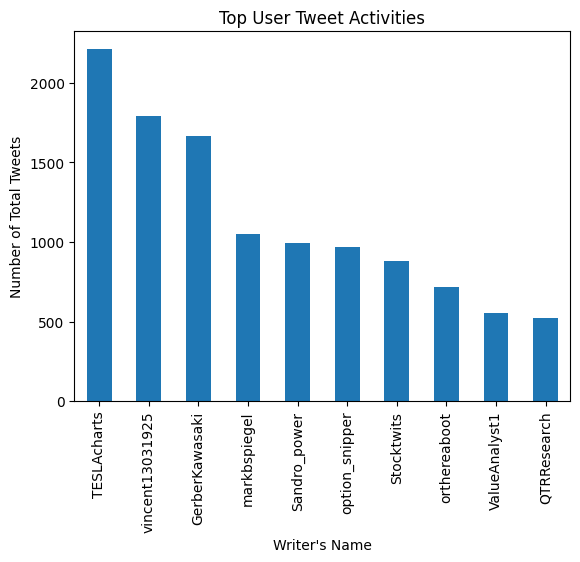

In [41]:

counts = filterTweets["writer"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("Writer's Name")
plt.show()

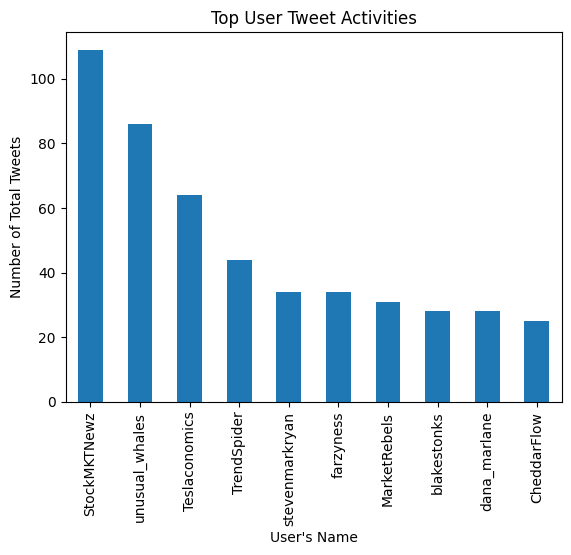

In [42]:
counts = filterCrawledTweets["user"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("User's Name")
plt.show()

Graph above shows active users/writers

<AxesSubplot: ylabel='ticker_symbol'>

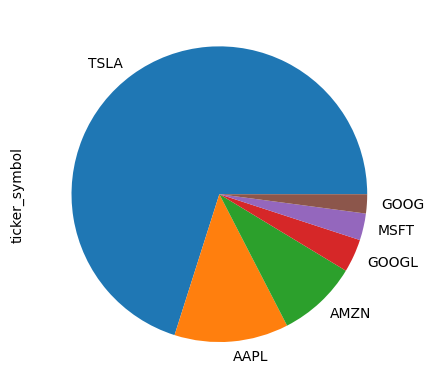

In [43]:
counts = filterTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

<AxesSubplot: ylabel='ticker_symbol'>

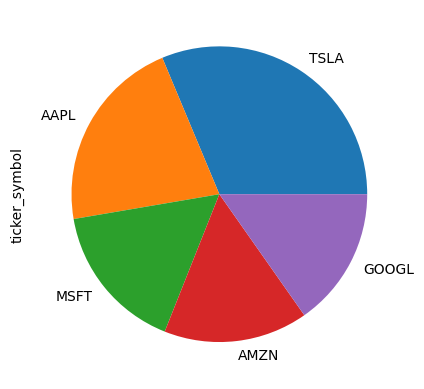

In [44]:
counts = filterCrawledTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

Notice that there are more TSLA tweets in the dataset.

### Active Tweets dates

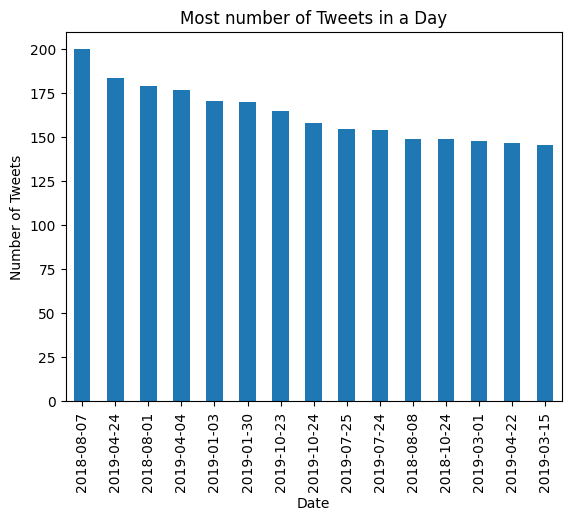

In [45]:
count = filterTweets["post_date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

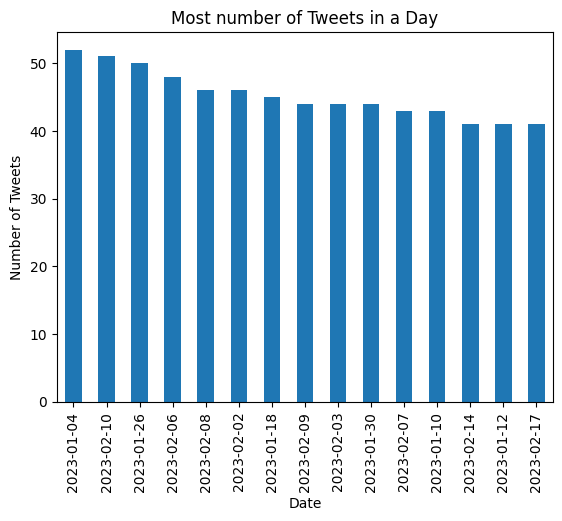

In [46]:
count = filterCrawledTweets["date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

Above bar graphs shows the highest tweets in the respective days

### Word Cloud of Tweets

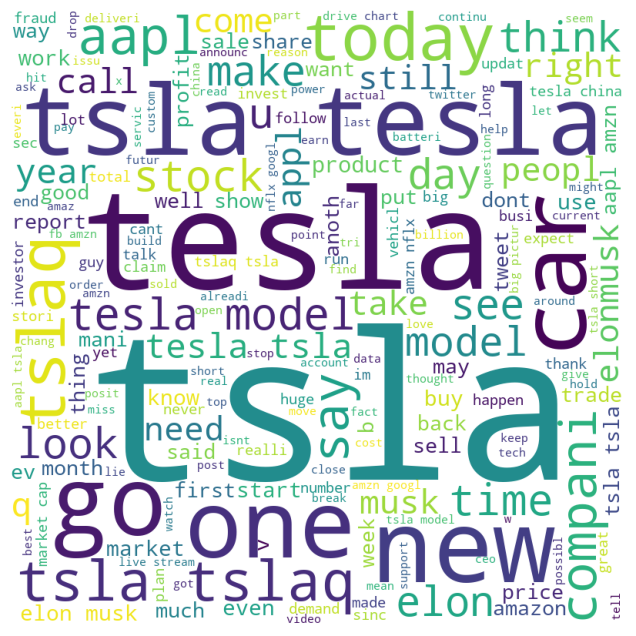

In [47]:
text = " ".join(filterTweets["body"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

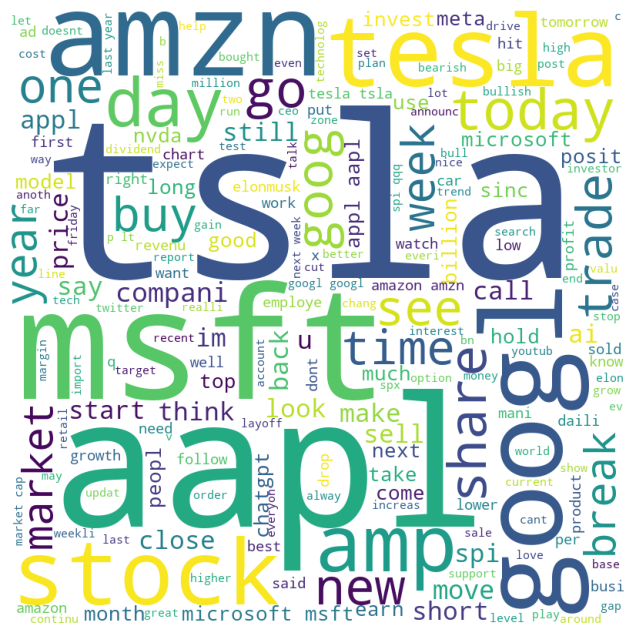

In [48]:
text = " ".join(filterCrawledTweets["tweet"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud we can tell that tsla aapl msft are common tweets in Twitter

# Polarity Detection

### Subjectivity and Polarity Analysis using Textblob

In [49]:
from textblob import TextBlob

In [50]:
# Function to use TextBlob (Sentimental Analysis [Objectivity & Polarity])

def add_sentiment_scores_blob(df, text_column, polarity_threshold = 0.0 , subjectivity_threshold = 0.5):
    # Compute polarity and subjectivity scores for each row in the specified text column
    scores = df[text_column].apply(lambda x: TextBlob(x).sentiment)
    
    # Add two new columns to the DataFrame for the polarity and subjectivity scores
    df['blob_polarity'] = scores.apply(lambda x: x.polarity)
    df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
    
    # Convert polarity score to class (positive, neutral, or negative) based on the specified threshold
    df['blob_polarity'] = df['blob_polarity'].apply(lambda x: 'Positive' if x > polarity_threshold else 'Negative' if x < -polarity_threshold else 'Neutral')
    
    # Convert subjectivity score to class (subjective or objective) based on the specified threshold
    df['blob_subjectivity'] = df['blob_subjectivity'].apply(lambda x: 'Subjective' if x > subjectivity_threshold else 'Objective')
    
    return df
    
    

In [51]:
add_sentiment_scores_blob(filterTweets,"body", 0.0, 0.5)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Negative,Objective


In [52]:
add_sentiment_scores_blob(filterTweetsLemma,"body", 0.0, 0.5)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Negative,Objective


In [53]:
add_sentiment_scores_blob(filterCrawledTweetsLemma,"tweet", 0.0, 0.5)
filterCrawledTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,Neutral,Objective
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,Positive,Subjective
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,Positive,Objective
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,Positive,Subjective
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,Neutral,Objective


In [54]:
add_sentiment_scores_blob(filterCrawledTweets,"tweet", 0.0, 0.5)
filterCrawledTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,Neutral,Objective
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,Positive,Subjective
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,Positive,Objective
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,Positive,Subjective
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,Neutral,Objective


### Convert Positive, Negative and Neutral to numeral labels and Subjectivity

In [55]:
sentiment_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
subjectivity_mapping = {"Subjective": 1, "Objective": 0}


In [56]:

filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)
filterTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2758484033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2758484033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,-1,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,-1,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,-1,0


In [57]:

filterTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)
filterTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2464247065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\2464247065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,-1,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,-1,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,-1,0


In [58]:

filterCrawledTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)
filterCrawledTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterCrawledTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\1030140890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterCrawledTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\1030140890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterCrawledTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)


,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,0,0
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,1,1
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,1,0
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,1,1
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,0,0


In [59]:

filterCrawledTweets["blob_polarity"].replace(sentiment_map, inplace = True)
filterCrawledTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterCrawledTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\1272302272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterCrawledTweets["blob_polarity"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_6192\1272302272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterCrawledTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)


,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,0,0
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,1,1
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,1,0
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,1,1
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,0,0


### Splitting up data for Prediction using ensemble machine learning models For Blob Subjectivity and Polarity Analysis

In [60]:
X = filterTweets["body"].values 
y = filterTweets["blob_polarity"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

In [61]:
X_lemma = filterTweetsLemma["body"].values 
y_lemma = filterTweetsLemma["blob_polarity"].values
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(
    X_lemma, y_lemma, test_size=0.20, random_state=0)

In [62]:
X_subj = filterTweets["body"].values 
y_subj = filterTweets["blob_subjectivity"].values
X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(
    X_subj, y_subj, test_size=0.20, random_state=0)

In [63]:
X_subj_lemma = filterTweetsLemma["body"].values 
y_subj_lemma = filterTweetsLemma["blob_subjectivity"].values
X_train_subj_lemma, X_test_subj_lemma, y_train_subj_lemma, y_test_subj_lemma = train_test_split(
    X_subj_lemma, y_subj_lemma, test_size=0.20, random_state=0)

In [64]:
X_crawled = filterCrawledTweets["tweet"].values 
y_crawled = filterCrawledTweets["blob_polarity"].values
X_train_crawled, X_test_crawled, y_train_crawled, y_test_crawled = train_test_split(
    X_crawled, y_crawled, test_size=0.20, random_state=0)

In [65]:
X_lemma_crawled = filterCrawledTweetsLemma["tweet"].values #["ticker_symbol","writer" , "body"]
y_lemma_crawled = filterCrawledTweetsLemma["blob_polarity"].values
X_train_crawled_lemma, X_test_crawled_lemma, y_train_crawled_lemma, y_test_crawled_lemma = train_test_split(
    X_lemma_crawled, y_lemma_crawled, test_size=0.20, random_state=0)

In [66]:
X_subj_crawled = filterCrawledTweets["tweet"].values #["ticker_symbol","writer" , "body"]
y_subj_crawled = filterCrawledTweets["blob_subjectivity"].values
X_train_subj_crawled, X_test_subj_crawled, y_train_subj_crawled, y_test_subj_crawled = train_test_split(
    X_subj_crawled, y_subj_crawled, test_size=0.20, random_state=0)

In [67]:
X_subj_crawled_lemma = filterCrawledTweetsLemma["tweet"].values #["ticker_symbol","writer" , "body"]
y_subj_crawled_lemma = filterCrawledTweetsLemma["blob_subjectivity"].values
X_train_subj_crawled_lemma, X_test_subj_crawled_lemma, y_train_subj_crawled_lemma, y_test_subj_crawled_lemma = train_test_split(
    X_subj_crawled_lemma, y_subj_crawled_lemma, test_size=0.20, random_state=0)

In [68]:
filterTweets["blob_polarity"].value_counts()

 0    18887
 1    15880
-1     6858
Name: blob_polarity, dtype: int64

In [69]:
filterCrawledTweets["blob_polarity"].value_counts()

 0    1039
 1     763
-1     335
Name: blob_polarity, dtype: int64

In [70]:
def metric_report(y_test,y_pred,time,no_record_x_test):
    accuracy = accuracy_score(y_test,y_pred)
    fmeasure = f1_score(y_test,y_pred, average = "weighted", zero_division = 1)
    recall = recall_score(y_test, y_pred, average = "weighted",zero_division = 1)
    precision = precision_score(y_test, y_pred, average = "weighted",zero_division = 1)
    print(f"The accuracy of the Model is {accuracy}")
    print(f"The F-Score of the Model is {fmeasure}")
    print(f"The Recall of the Model is {recall}")
    print(f"The precision of the Model is {precision}")
    print(f"The time taken for the Model prediction is {time} seconds")
    print(f"The number of records per second is {no_record_x_test//time}")

### Vectorise and TFIDF train and test datas

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [72]:
# Create Count Vectorizer (TF)
vectoriser = CountVectorizer()

# For blob analysis dataset that have been stemmed

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

X_train_crawled_vec = vectoriser.fit_transform(X_train_crawled)
X_test_crawled_vec = vectoriser.transform(X_test_crawled)


# For blob analysis dataset that have been lemmatised
X_train_lemma_vec = vectoriser.fit_transform(X_train_lemma)
X_test_lemma_vec = vectoriser.transform(X_test_lemma)

X_train_crawled_lemma_vec = vectoriser.fit_transform(X_train_crawled_lemma)
X_test_crawled_lemma_vec = vectoriser.transform(X_test_crawled_lemma)


# For Subjectivity Blob Analysis Vectorised
X_train_subj_vec = vectoriser.fit_transform(X_train_subj)
X_test_subj_vec = vectoriser.transform(X_test_subj)

X_train_subj_lemma_vec = vectoriser.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_vec = vectoriser.transform(X_test_subj_lemma)

X_train_subj_crawled_vec = vectoriser.fit_transform(X_train_subj_crawled)
X_test_subj_crawled_vec = vectoriser.transform(X_test_subj_crawled)

X_train_subj_crawled_lemma_vec = vectoriser.fit_transform(X_train_subj_crawled_lemma)
X_test_subj_crawled_lemma_vec = vectoriser.transform(X_test_subj_crawled_lemma)


# Create TFID Vectorizer 
vectoriser_tfidf = TfidfVectorizer()
# For blob analysis dataset that have been stemmed


X_train_tfidf = vectoriser_tfidf.fit_transform(X_train)
X_test_tfidf = vectoriser_tfidf.transform(X_test)

X_train_crawled_tfidf = vectoriser_tfidf.fit_transform(X_train_crawled)
X_test_crawled_tfidf = vectoriser_tfidf.transform(X_test_crawled)

# For blob analysis dataset  that have been lemmatised


X_train_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_lemma)
X_test_lemma_tfidf = vectoriser_tfidf.transform(X_test_lemma)

X_train_crawled_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_crawled_lemma)
X_test_crawled_lemma_tfidf = vectoriser_tfidf.transform(X_test_crawled_lemma)


# For Subjectivity Blob Analysis TFIDF
X_train_subj_tfidf = vectoriser_tfidf.fit_transform(X_train_subj)
X_test_subj_tfidf = vectoriser_tfidf.transform(X_test_subj)


X_train_subj_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_tfidf = vectoriser_tfidf.transform(X_test_subj_lemma)


X_train_subj_crawled_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_crawled)
X_test_subj_crawled_tfidf = vectoriser_tfidf.transform(X_test_subj_crawled)

X_train_subj_crawled_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_crawled_lemma)
X_test_subj_crawled_lemma_tfidf = vectoriser_tfidf.transform(X_test_subj_crawled_lemma)




## Doing up Machine Learning Models for TextBlob Analysis

## Subjectivity Prediction

### Naive Bayes ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [73]:
def multi_nb_clf(X_train, y_train, X_test, y_test):
    # Train the model using Naive Bayes algorithm
    clf = MultinomialNB()
    test_size = len(y_test)
    clf.fit(X_train, y_train)
    # Make predictions on test data
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    # Evaluate the model using accuracy score
    metric_report(y_test,y_pred,time_taken,test_size)
    

In [74]:
# Naive Bayes for Stemmed Dataset and Vectorised
multi_nb_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.8521321321321321
The F-Score of the Model is 0.8418824241194104
The Recall of the Model is 0.8521321321321321
The precision of the Model is 0.8460482816960783
The time taken for the Model prediction is 0.0009970664978027344 seconds
The number of records per second is 8349493.0


In [75]:
# Naive Bayes for Lemmatised and Vectorised
multi_nb_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8521321321321321
The F-Score of the Model is 0.8418824241194104
The Recall of the Model is 0.8521321321321321
The precision of the Model is 0.8460482816960783
The time taken for the Model prediction is 0.0009975433349609375 seconds
The number of records per second is 8345502.0


In [76]:
# Naive Bayes for stemmed crawled dataset and Vectorised
multi_nb_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.7967289719626168
The F-Score of the Model is 0.751567766598054
The Recall of the Model is 0.7967289719626168
The precision of the Model is 0.7729588230970594
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [77]:
# Naive Bayes for lemmatised crawled dataset and Vectorised
multi_nb_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7967289719626168
The F-Score of the Model is 0.751567766598054
The Recall of the Model is 0.7967289719626168
The precision of the Model is 0.7729588230970594
The time taken for the Model prediction is 0.0009970664978027344 seconds
The number of records per second is 429259.0


In [78]:
# Naive Bayes for stemmed crawled dataset and TFIDF
multi_nb_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.7646846846846846
The F-Score of the Model is 0.6705860569871012
The Recall of the Model is 0.7646846846846846
The precision of the Model is 0.8135430634122495
The time taken for the Model prediction is 0.0009970664978027344 seconds
The number of records per second is 8349493.0


In [79]:
# Naive Bayes for lemmatised crawled dataset and TFIDF
multi_nb_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.7646846846846846
The F-Score of the Model is 0.6705860569871012
The Recall of the Model is 0.7646846846846846
The precision of the Model is 0.8135430634122495
The time taken for the Model prediction is 0.000997304916381836 seconds
The number of records per second is 8347497.0


In [80]:
# Naive Bayes for stemmed crawled dataset and TFIDF
multi_nb_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [81]:
# Naive Bayes for lemmatised crawled dataset and TFIDF
multi_nb_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model prediction is 0.0010221004486083984 seconds
The number of records per second is 418745.0


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [84]:
def dt_clf(X_train, y_train, X_test,y_test):
    clf = DecisionTreeClassifier()
    clf.fit(X_train,y_train)
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    
    metric_report(y_test,y_pred,time_taken,len(y_test))

In [85]:
# Decision Tree Classifier (subjectivity) for Stemmed Dataset and vectorised
dt_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9322522522522523
The F-Score of the Model is 0.9330646033296635
The Recall of the Model is 0.9322522522522523
The precision of the Model is 0.9346444616006859
The time taken for the Model prediction is 0.00399017333984375 seconds
The number of records per second is 2086375.0


In [86]:
# Decision Tree Classifier (subjectivity) for lemmatised Dataset and vectorised
dt_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.9316516516516516
The F-Score of the Model is 0.9324863770542535
The Recall of the Model is 0.9316516516516516
The precision of the Model is 0.9341177027744292
The time taken for the Model prediction is 0.003997802734375 seconds
The number of records per second is 2082393.0


In [87]:
# Decision Tree Classifier (subjectivity) for Stemmed crawled Dataset and vectorised
dt_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8621495327102804
The F-Score of the Model is 0.8628970983771838
The Recall of the Model is 0.8621495327102804
The precision of the Model is 0.8637478382954621
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [88]:
# Decision Tree Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
dt_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8598130841121495
The F-Score of the Model is 0.8612979782198315
The Recall of the Model is 0.8598130841121495
The precision of the Model is 0.8631874858767543
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [89]:
# Decision Tree Classifier (subjectivity) for stemmed Dataset and tfidf
dt_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.922042042042042
The F-Score of the Model is 0.9231760738357596
The Recall of the Model is 0.922042042042042
The precision of the Model is 0.9254399968494852
The time taken for the Model prediction is 0.004987001419067383 seconds
The number of records per second is 1669339.0


In [90]:
# Decision Tree Classifier (subjectivity) for lemmatised Dataset and tfidf
dt_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.9204804804804805
The F-Score of the Model is 0.9214809610735101
The Recall of the Model is 0.9204804804804805
The precision of the Model is 0.9233117403708513
The time taken for the Model prediction is 0.004984855651855469 seconds
The number of records per second is 1670058.0


In [91]:
# Decision Tree Classifier (subjectivity) for stemmed crawled Dataset and tfidf
dt_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8551401869158879
The F-Score of the Model is 0.854595274073877
The Recall of the Model is 0.8551401869158879
The precision of the Model is 0.8540965394722585
The time taken for the Model prediction is 0.000989675521850586 seconds
The number of records per second is 432464.0


In [92]:
# Decision Tree Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
dt_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8598130841121495
The F-Score of the Model is 0.8587414552481831
The Recall of the Model is 0.8598130841121495
The precision of the Model is 0.8578587875621603
The time taken for the Model prediction is 0.0009951591491699219 seconds
The number of records per second is 430081.0


### Random Forest ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
def rf_clf(X_train, y_train, X_test, y_test):
    
    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,y_pred,time_taken,len(y_test))


In [95]:
# Random Forest Classifier (subjectivity) for Stemmed Dataset and vectorised
rf_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9334534534534534
The F-Score of the Model is 0.9341619935499383
The Recall of the Model is 0.9334534534534534
The precision of the Model is 0.9354711738623777
The time taken for the Model prediction is 0.7813901901245117 seconds
The number of records per second is 10654.0


In [96]:
# Random Forest Classifier (subjectivity) for lemmatised Dataset and vectorised
rf_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.9324924924924924
The F-Score of the Model is 0.9331807314438221
The Recall of the Model is 0.9324924924924924
The precision of the Model is 0.9344169190493843
The time taken for the Model prediction is 0.7773556709289551 seconds
The number of records per second is 10709.0


In [97]:
# Random Forest Classifier (subjectivity) for Stemmed crawled Dataset and vectorised
rf_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8411214953271028
The F-Score of the Model is 0.8288860242775808
The Recall of the Model is 0.8411214953271028
The precision of the Model is 0.830363561671973
The time taken for the Model prediction is 0.023935317993164062 seconds
The number of records per second is 17881.0


In [98]:
# Random Forest Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
rf_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.819774594866971
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8217911847204382
The time taken for the Model prediction is 0.027441024780273438 seconds
The number of records per second is 15597.0


In [99]:
# Random Forest Classifier (subjectivity) for Stemmed Dataset and tfidf
rf_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9282882882882882
The F-Score of the Model is 0.9278871360795595
The Recall of the Model is 0.9282882882882882
The precision of the Model is 0.9276340830830585
The time taken for the Model prediction is 0.7505331039428711 seconds
The number of records per second is 11092.0


In [100]:
# Random Forest Classifier (subjectivity) for lemmatised Dataset and tfidf
rf_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.9303303303303303
The F-Score of the Model is 0.9299590372164026
The Recall of the Model is 0.9303303303303303
The precision of the Model is 0.9297229146322312
The time taken for the Model prediction is 0.7580933570861816 seconds
The number of records per second is 10981.0


In [101]:
# Random Forest Classifier (subjectivity) for stemmed crawled Dataset and tfidf
rf_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.8086171894611945
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8281356114001189
The time taken for the Model prediction is 0.02490377426147461 seconds
The number of records per second is 17186.0


In [102]:
# Random Forest Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
rf_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.822429906542056
The F-Score of the Model is 0.7894309439205397
The Recall of the Model is 0.822429906542056
The precision of the Model is 0.8155953970373196
The time taken for the Model prediction is 0.021945714950561523 seconds
The number of records per second is 19502.0


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [103]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [104]:
def ensemble_clf(X_train, y_train, X_test, y_test):
    clf1 = DecisionTreeClassifier()
    clf2 = RandomForestClassifier()
    clf3 = SVC()

    # Create the ensemble classifier
    ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
    
    # Train the ensemble classifier
    ensemble.fit(X_train,y_train)
    start_time = time.time()
    # Make predictions on the test set
    y_pred = ensemble.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    # Evaluate the accuracy of the model
    metric_report(y_test,y_pred,time_taken, len(y_test))

In [105]:
# Ensemble Classifier (subjectivity) for stemmed Dataset and vectorised
ensemble_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9394594594594594
The F-Score of the Model is 0.9395301226120477
The Recall of the Model is 0.9394594594594594
The precision of the Model is 0.9396076426504777
The time taken for the Model prediction is 20.310806035995483 seconds
The number of records per second is 409.0


In [106]:
# Ensemble Classifier (subjectivity) for lemmatised Dataset and vectorised
ensemble_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.9418618618618618
The F-Score of the Model is 0.9420631651538478
The Recall of the Model is 0.9418618618618618
The precision of the Model is 0.9423259554240522
The time taken for the Model prediction is 20.17292332649231 seconds
The number of records per second is 412.0


In [107]:
# Ensemble Classifier (subjectivity) for stemmed crawled Dataset and vectorised
ensemble_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.819774594866971
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8217911847204382
The time taken for the Model prediction is 0.0942225456237793 seconds
The number of records per second is 4542.0


In [108]:
# Ensemble Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
ensemble_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.8208244164033226
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8218434320341887
The time taken for the Model prediction is 0.09229683876037598 seconds
The number of records per second is 4637.0


In [109]:
# Ensemble Classifier (subjectivity) for stemmed Dataset and tfidf
ensemble_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9342942942942943
The F-Score of the Model is 0.9340532849215324
The Recall of the Model is 0.9342942942942943
The precision of the Model is 0.9338774249186692
The time taken for the Model prediction is 21.650420427322388 seconds
The number of records per second is 384.0


In [110]:
# Ensemble Classifier (subjectivity) for lemmatised Dataset and tfidf

ensemble_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.9368168168168168
The F-Score of the Model is 0.9364800923721168
The Recall of the Model is 0.9368168168168168
The precision of the Model is 0.9362802873118676
The time taken for the Model prediction is 21.484495639801025 seconds
The number of records per second is 387.0


In [111]:
# Ensemble Classifier (subjectivity) for stemmed crawled Dataset and tfidf

ensemble_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8364485981308412
The F-Score of the Model is 0.8091365829821024
The Recall of the Model is 0.8364485981308412
The precision of the Model is 0.8347962231428847
The time taken for the Model prediction is 0.09433984756469727 seconds
The number of records per second is 4536.0


In [112]:
# Ensemble Classifier (subjectivity) for lemmatised crawled Dataset and tfidf

ensemble_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8411214953271028
The F-Score of the Model is 0.8115961077183775
The Recall of the Model is 0.8411214953271028
The precision of the Model is 0.8484328310763557
The time taken for the Model prediction is 0.09728646278381348 seconds
The number of records per second is 4399.0


### Support Vector Machine Model

In [113]:
def svm_clf(X_train,y_train,X_test, y_test):
    clf = SVC(kernel = "rbf",random_state = 1)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    svm_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,svm_pred,time_taken, len(y_test))

In [114]:
# SVM Classifier (subjectivity) for stemmed Dataset and vectorised

svm_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9207207207207208
The F-Score of the Model is 0.9181966825217822
The Recall of the Model is 0.9207207207207208
The precision of the Model is 0.9198374177944413
The time taken for the Model prediction is 18.698935508728027 seconds
The number of records per second is 445.0


In [115]:
# SVM Classifier (subjectivity) for lemmatised Dataset and vectorised
svm_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.9207207207207208
The F-Score of the Model is 0.9181966825217822
The Recall of the Model is 0.9207207207207208
The precision of the Model is 0.9198374177944413
The time taken for the Model prediction is 18.859139442443848 seconds
The number of records per second is 441.0


In [116]:
# SVM Classifier (subjectivity) for stemmed crawled Dataset and vectorised
svm_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.780373831775701
The F-Score of the Model is 0.688660895769054
The Recall of the Model is 0.780373831775701
The precision of the Model is 0.8288359440129877
The time taken for the Model prediction is 0.06337666511535645 seconds
The number of records per second is 6753.0


In [117]:
# SVM Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
svm_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.780373831775701
The F-Score of the Model is 0.688660895769054
The Recall of the Model is 0.780373831775701
The precision of the Model is 0.8288359440129877
The time taken for the Model prediction is 0.06244993209838867 seconds
The number of records per second is 6853.0


In [118]:
# SVM Classifier (subjectivity) for stemmed Dataset and tfidf
svm_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.924084084084084
The F-Score of the Model is 0.9216174027024687
The Recall of the Model is 0.924084084084084
The precision of the Model is 0.9235101766718081
The time taken for the Model prediction is 19.932718992233276 seconds
The number of records per second is 417.0


In [119]:
# SVM Classifier (subjectivity) for lemmatised Dataset and tfidf
svm_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.924084084084084
The F-Score of the Model is 0.9216174027024687
The Recall of the Model is 0.924084084084084
The precision of the Model is 0.9235101766718081
The time taken for the Model prediction is 19.993816614151 seconds
The number of records per second is 416.0


In [120]:
# SVM Classifier (subjectivity) for stemmed crawled Dataset and tfidf
svm_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.7850467289719626
The F-Score of the Model is 0.7030431796407798
The Recall of the Model is 0.7850467289719626
The precision of the Model is 0.7953448199495062
The time taken for the Model prediction is 0.0733175277709961 seconds
The number of records per second is 5837.0


In [121]:
# SVM Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
svm_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7850467289719626
The F-Score of the Model is 0.7030431796407798
The Recall of the Model is 0.7850467289719626
The precision of the Model is 0.7953448199495062
The time taken for the Model prediction is 0.07280516624450684 seconds
The number of records per second is 5878.0


### Neural Network Model



In [122]:
from sklearn.neural_network import MLPClassifier

In [268]:
def mlp_clf(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,2), random_state=1, max_iter = 1000)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    nn_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,nn_pred,time_taken,len(y_test))

In [269]:
# Multilayer Perceptron for Stemmed Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.7568768768768769
The F-Score of the Model is 0.6521374540135649
The Recall of the Model is 0.7568768768768769
The precision of the Model is 0.8159857298740182
The time taken for the Model prediction is 0.017963647842407227 seconds
The number of records per second is 463435.0


In [270]:
# Multilayer Perceptron for lemmatised Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.7568768768768769
The F-Score of the Model is 0.6521374540135649
The Recall of the Model is 0.7568768768768769
The precision of the Model is 0.8159857298740182
The time taken for the Model prediction is 0.016578197479248047 seconds
The number of records per second is 502165.0


In [271]:
# Multilayer Perceptron for Stemmed crawled Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.8164146405593693
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8223684060671357
The time taken for the Model prediction is 0.0025763511657714844 seconds
The number of records per second is 166126.0


In [272]:
# Multilayer Perceptron for lemmatised crawled Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8341121495327103
The F-Score of the Model is 0.8164146405593693
The Recall of the Model is 0.8341121495327103
The precision of the Model is 0.8223684060671357
The time taken for the Model prediction is 0.0009965896606445312 seconds
The number of records per second is 429464.0


In [273]:
# Multilayer Perceptron for Stemmed Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.7568768768768769
The F-Score of the Model is 0.6521374540135649
The Recall of the Model is 0.7568768768768769
The precision of the Model is 0.8159857298740182
The time taken for the Model prediction is 0.020276784896850586 seconds
The number of records per second is 410568.0


In [274]:
# Multilayer Perceptron for lemmatised Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.7568768768768769
The F-Score of the Model is 0.6521374540135649
The Recall of the Model is 0.7568768768768769
The precision of the Model is 0.8159857298740182
The time taken for the Model prediction is 0.02074909210205078 seconds
The number of records per second is 401222.0


In [275]:
# Multilayer Perceptron for Stemmed crawled Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8271028037383178
The F-Score of the Model is 0.8127109040821369
The Recall of the Model is 0.8271028037383178
The precision of the Model is 0.8131977838951848
The time taken for the Model prediction is 0.001817941665649414 seconds
The number of records per second is 235431.0


In [276]:
# Multilayer Perceptron for lemmatised crawled Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8271028037383178
The F-Score of the Model is 0.8127109040821369
The Recall of the Model is 0.8271028037383178
The precision of the Model is 0.8131977838951848
The time taken for the Model prediction is 0.0009968280792236328 seconds
The number of records per second is 429361.0


### TensorFlow Subjectivity Machine Modeling

In [277]:
# Define the model architecture
model_vec2_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj = model_vec2_subj.fit(X_train_subj_vec, y_train_subj, epochs=5, batch_size=32, validation_data=(X_test_subj_vec, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_subj.load_weights("model_polarity_subj_vec2.h5")
test_loss, test_acc = model_vec2_subj.evaluate(X_test_subj_vec, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec2_subj.predict(X_test_subj_vec)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_subj, y_pred,time_taken,len(y_test_subj))

Epoch 1/5
1041/1041 [==============================] - 21s 19ms/step - loss: 0.2751 - accuracy: 0.8921 - val_loss: 0.1781 - val_accuracy: 0.9337
Epoch 2/5
1041/1041 [==============================] - 20s 20ms/step - loss: 0.0628 - accuracy: 0.9778 - val_loss: 0.1690 - val_accuracy: 0.9421
Epoch 3/5
1041/1041 [==============================] - 20s 19ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.2116 - val_accuracy: 0.9426
Epoch 4/5
1041/1041 [==============================] - 20s 19ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.2544 - val_accuracy: 0.9443
Epoch 5/5
261/261 [==============================] - 0s 863us/step - loss: 0.1690 - accuracy: 0.9421
Test loss: 0.16897103190422058
Test accuracy: 0.9421020746231079
261/261 [==============================] - 0s 753us/step
The accuracy of the Model is 0.9421021021021021
The F-Score of the Model is 0.9419646458242551
The Recall of the Model is 0.9421021021021021
The precision of the Model is 0.941855107695982
The time

{'accuracy': 0.9421021021021021,
 'fmeasure': 0.9419646458242551,
 'recall': 0.9421021021021021,
 'precision': 0.941855107695982,
 'time': 0.34717535972595215}

In [278]:
# Define the model architecture
model_vec2_lemma_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_lemma_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj_lemma = model_vec2_lemma_subj.fit(X_train_subj_lemma_vec, y_train_subj_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_lemma_vec, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_lemma_subj.load_weights("model_polarity_subj_lemma_vec2.h5")
test_loss, test_acc = model_vec2_lemma_subj.evaluate(X_test_subj_lemma_vec, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_vec2_lemma_subj.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma,y_pred,time_taken, len(y_test_subj_lemma))

Epoch 1/5
1041/1041 [==============================] - 21s 19ms/step - loss: 0.2798 - accuracy: 0.8906 - val_loss: 0.1782 - val_accuracy: 0.9330
Epoch 2/5
1041/1041 [==============================] - 20s 20ms/step - loss: 0.0576 - accuracy: 0.9802 - val_loss: 0.1870 - val_accuracy: 0.9402
Epoch 3/5
1041/1041 [==============================] - 20s 19ms/step - loss: 0.0161 - accuracy: 0.9945 - val_loss: 0.2050 - val_accuracy: 0.9435
Epoch 4/5
1041/1041 [==============================] - 21s 20ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.2448 - val_accuracy: 0.9401
Epoch 5/5
261/261 [==============================] - 0s 866us/step - loss: 0.1782 - accuracy: 0.9330
Test loss: 0.1782243400812149
Test accuracy: 0.9329729676246643
261/261 [==============================] - 0s 752us/step
The accuracy of the Model is 0.932972972972973
The F-Score of the Model is 0.9324001066749995
The Recall of the Model is 0.932972972972973
The precision of the Model is 0.9321706034192946
The time t

{'accuracy': 0.932972972972973,
 'fmeasure': 0.9324001066749995,
 'recall': 0.932972972972973,
 'precision': 0.9321706034192946,
 'time': 0.3406105041503906}

In [279]:
# Crawled Dataset
# Define the model architecture
model_crawled_vec2_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_crawled_vec2_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_subj_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2_subj = model_crawled_vec2_subj.fit(X_train_subj_crawled_vec, y_train_subj_crawled, epochs=5, batch_size=32, validation_data=(X_test_subj_crawled_vec, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2_subj.load_weights("model_crawled_polarity_subj_vec2.h5")
test_loss, test_acc = model_crawled_vec2_subj.evaluate(X_test_subj_crawled_vec, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time =  time.time()
y_pred = model_crawled_vec2_subj.predict(X_test_subj_crawled_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/5
54/54 [==============================] - 1s 6ms/step - loss: 0.5642 - accuracy: 0.7899 - val_loss: 0.5282 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 0s 3ms/step - loss: 0.3568 - accuracy: 0.8069 - val_loss: 0.5374 - val_accuracy: 0.7991
Epoch 3/5
54/54 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.9754 - val_loss: 0.8815 - val_accuracy: 0.8154
Epoch 4/5
54/54 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9977 - val_loss: 0.9978 - val_accuracy: 0.8154
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: 0.5282 - accuracy: 0.7757
Test loss: 0.5281932950019836
Test accuracy: 0.7757009267807007
14/14 [==============================] - 0s 844us/step
The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model predictio

{'accuracy': 0.7757009345794392,
 'fmeasure': 0.6777176586325627,
 'recall': 0.7757009345794392,
 'precision': 0.8260110053279762,
 'time': 0.09027457237243652}

In [280]:
# Crawled Data
# Define the model architecture
model_crawled_vec2_lemma_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_crawled_vec2_lemma_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_subj_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2_subj_lemma = model_crawled_vec2_lemma_subj.fit(X_train_subj_crawled_lemma_vec, y_train_subj_crawled_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_crawled_lemma_vec, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2_lemma_subj.load_weights("model_crawled_polarity_subj_lemma_vec2.h5")
test_loss, test_acc = model_crawled_vec2_lemma_subj.evaluate(X_test_subj_crawled_lemma_vec, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_vec2_lemma_subj.predict(X_test_subj_crawled_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma, y_pred, time_taken, len(y_test_subj_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 1s 6ms/step - loss: 0.5491 - accuracy: 0.7899 - val_loss: 0.5255 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 0s 3ms/step - loss: 0.3502 - accuracy: 0.8022 - val_loss: 0.5533 - val_accuracy: 0.7944
Epoch 3/5
54/54 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9789 - val_loss: 0.8454 - val_accuracy: 0.8107
Epoch 4/5
54/54 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 1.0819 - val_accuracy: 0.8154
Epoch 5/5
14/14 [==============================] - 0s 998us/step - loss: 0.5255 - accuracy: 0.7757
Test loss: 0.5254551768302917
Test accuracy: 0.7757009267807007
14/14 [==============================] - 0s 829us/step
The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model predict

{'accuracy': 0.7757009345794392,
 'fmeasure': 0.6777176586325627,
 'recall': 0.7757009345794392,
 'precision': 0.8260110053279762,
 'time': 0.08463525772094727}

In [281]:
Xtest = X_test_subj_tfidf
Xtest = Xtest.toarray()
print(Xtest.shape)

(8325, 34083)


In [282]:
print(len(y_test_subj))

8325


In [283]:

# Define the model architecture
model_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf_subj
model_tfidf_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_tfidf.h5", save_best_only=True)

# Train the model_tfidf_subj
history_subj_tfidf = model_tfidf_subj.fit(X_train_subj_tfidf, y_train_subj, epochs=5, batch_size=32, validation_data=(X_test_subj_tfidf, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf_subj on the test set
model_tfidf_subj.load_weights("model_subj_tfidf.h5")
test_loss, test_acc = model_tfidf_subj.evaluate(X_test_subj_tfidf, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()

y_pred = model_tfidf_subj.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)


metric_report(y_test_subj, y_pred,time_taken,len(y_test_subj))

Epoch 1/5
1041/1041 [==============================] - 22s 21ms/step - loss: 0.2988 - accuracy: 0.8745 - val_loss: 0.1996 - val_accuracy: 0.9218
Epoch 2/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0664 - accuracy: 0.9762 - val_loss: 0.1991 - val_accuracy: 0.9331
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.2708 - val_accuracy: 0.9350
Epoch 4/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.3400 - val_accuracy: 0.9378
Epoch 5/5
261/261 [==============================] - 0s 889us/step - loss: 0.1991 - accuracy: 0.9331
Test loss: 0.19912639260292053
Test accuracy: 0.9330930709838867
261/261 [==============================] - 0s 748us/step
The accuracy of the Model is 0.9330930930930931
The F-Score of the Model is 0.9313412986111859
The Recall of the Model is 0.9330930930930931
The precision of the Model is 0.9325525092418953
The tim

{'accuracy': 0.9330930930930931,
 'fmeasure': 0.9313412986111859,
 'recall': 0.9330930930930931,
 'precision': 0.9325525092418953,
 'time': 0.33852648735046387}

In [284]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_subj_lemma_tfidf = model_lemma_tfidf.fit(X_train_subj_lemma_tfidf, y_train_subj_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_lemma_tfidf, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_subj_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_subj_lemma_tfidf, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_tfidf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma, y_pred,time_taken, len(y_test_subj_lemma))

Epoch 1/5
1041/1041 [==============================] - 22s 20ms/step - loss: 0.2935 - accuracy: 0.8791 - val_loss: 0.1944 - val_accuracy: 0.9242
Epoch 2/5
1041/1041 [==============================] - 21s 20ms/step - loss: 0.0645 - accuracy: 0.9765 - val_loss: 0.2028 - val_accuracy: 0.9320
Epoch 3/5
1041/1041 [==============================] - 21s 21ms/step - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.2197 - val_accuracy: 0.9345
Epoch 4/5
1041/1041 [==============================] - 22s 21ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.3147 - val_accuracy: 0.9332
Epoch 5/5
261/261 [==============================] - 0s 857us/step - loss: 0.1944 - accuracy: 0.9242
Test loss: 0.1943669617176056
Test accuracy: 0.9242042303085327
261/261 [==============================] - 0s 790us/step
The accuracy of the Model is 0.9242042042042042
The F-Score of the Model is 0.9245217369639757
The Recall of the Model is 0.9242042042042042
The precision of the Model is 0.9249267032815948
The time

{'accuracy': 0.9242042042042042,
 'fmeasure': 0.9245217369639757,
 'recall': 0.9242042042042042,
 'precision': 0.9249267032815948,
 'time': 0.3583054542541504}

In [285]:
# Crawled Dataset
# Define the model architecture
model_crawled_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_tfidf_subj
model_crawled_tfidf_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_tfidf.h5", save_best_only=True)

# Train the model_crawled_tfidf_subj
history_crawled_subj_tfidf = model_crawled_tfidf_subj.fit(X_train_subj_crawled_tfidf, y_train_subj_crawled, epochs=5, batch_size=32, validation_data=(X_test_subj_crawled_tfidf, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_tfidf_subj on the test set
model_crawled_tfidf_subj.load_weights("model_crawled_subj_tfidf.h5")
test_loss, test_acc = model_crawled_tfidf_subj.evaluate(X_test_subj_crawled_tfidf, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time =  time.time()
y_pred = model_crawled_tfidf_subj.predict(X_test_subj_crawled_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/5
54/54 [==============================] - 1s 6ms/step - loss: 0.5849 - accuracy: 0.7741 - val_loss: 0.5189 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 0s 4ms/step - loss: 0.4118 - accuracy: 0.7905 - val_loss: 0.4974 - val_accuracy: 0.7757
Epoch 3/5
54/54 [==============================] - 0s 3ms/step - loss: 0.2081 - accuracy: 0.8929 - val_loss: 0.6255 - val_accuracy: 0.8061
Epoch 4/5
54/54 [==============================] - 0s 3ms/step - loss: 0.0360 - accuracy: 0.9965 - val_loss: 0.9548 - val_accuracy: 0.7944
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: 0.4974 - accuracy: 0.7757
Test loss: 0.4973966181278229
Test accuracy: 0.7757009267807007
14/14 [==============================] - 0s 873us/step
The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model predictio

{'accuracy': 0.7757009345794392,
 'fmeasure': 0.6777176586325627,
 'recall': 0.7757009345794392,
 'precision': 0.8260110053279762,
 'time': 0.0894315242767334}

In [286]:
# Crawled Dataset
# Define the model architecture
model_crawled_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_lemma_tfidf
model_crawled_lemma_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_lemma_tfidf.h5", save_best_only=True)

# Train the model_crawled_lemma_tfidf
history_crawled_subj_lemma_tfidf = model_crawled_lemma_tfidf.fit(X_train_subj_crawled_lemma_tfidf, y_train_subj_crawled_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_crawled_lemma_tfidf, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_tfidf on the test set
model_crawled_lemma_tfidf.load_weights("model_crawled_subj_lemma_tfidf.h5")
test_loss, test_acc = model_crawled_lemma_tfidf.evaluate(X_test_subj_crawled_lemma_tfidf, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_lemma_tfidf.predict(X_test_subj_crawled_lemma_tfidf)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma,y_pred,time_taken,len(y_test_subj_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 1s 9ms/step - loss: 0.6030 - accuracy: 0.7788 - val_loss: 0.5291 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 0s 7ms/step - loss: 0.4579 - accuracy: 0.7905 - val_loss: 0.5052 - val_accuracy: 0.7757
Epoch 3/5
54/54 [==============================] - 0s 6ms/step - loss: 0.3742 - accuracy: 0.7975 - val_loss: 0.4722 - val_accuracy: 0.7827
Epoch 4/5
54/54 [==============================] - 0s 6ms/step - loss: 0.2604 - accuracy: 0.8988 - val_loss: 0.4612 - val_accuracy: 0.7991
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.8084
Test loss: 0.4582526385784149
Test accuracy: 0.8084112405776978
14/14 [==============================] - 0s 921us/step
The accuracy of the Model is 0.8084112149532711
The F-Score of the Model is 0.7625829242521841
The Recall of the Model is 0.8084112149532711
The precision of the Model is 0.8015887492801986
The time taken for the Model predictio

{'accuracy': 0.8084112149532711,
 'fmeasure': 0.7625829242521841,
 'recall': 0.8084112149532711,
 'precision': 0.8015887492801986,
 'time': 0.07930183410644531}

In [287]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj)
test_sequence = tokenizer.texts_to_sequences(X_test_subj)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_subj_vec
model_subj_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_vec.h5", save_best_only=True)

# Train the model_subj_vec
history_subj_vec = model_subj_vec.fit(pad_train, y_train_subj, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_vec on the test set
model_subj_vec.load_weights("model_subj_vec.h5")
test_loss, test_acc = model_subj_vec.evaluate(pad_test, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_subj_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj,y_pred,time_taken,len(y_test_subj))

Epoch 1/5
1041/1041 [==============================] - 74s 69ms/step - loss: 0.1905 - accuracy: 0.9223 - val_loss: 0.0838 - val_accuracy: 0.9683
Epoch 2/5
1041/1041 [==============================] - 115s 111ms/step - loss: 0.0471 - accuracy: 0.9825 - val_loss: 0.0913 - val_accuracy: 0.9636
Epoch 3/5
1041/1041 [==============================] - 114s 110ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.1099 - val_accuracy: 0.9641
Epoch 4/5
1041/1041 [==============================] - 115s 110ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.1225 - val_accuracy: 0.9625
Epoch 5/5
261/261 [==============================] - 6s 21ms/step - loss: 0.0838 - accuracy: 0.9683
Test loss: 0.08377581089735031
Test accuracy: 0.9682883024215698
261/261 [==============================] - 6s 21ms/step
The accuracy of the Model is 0.9682882882882883
The F-Score of the Model is 0.9684134745108339
The Recall of the Model is 0.9682882882882883
The precision of the Model is 0.9686228057122028
The

{'accuracy': 0.9682882882882883,
 'fmeasure': 0.9684134745108339,
 'recall': 0.9682882882882883,
 'precision': 0.9686228057122028,
 'time': 6.092654705047607}

In [288]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_lemma)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_lemma)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_subj_lemma_vec
model_subj_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_vec.h5", save_best_only=True)

# Train the model_subj_lemma_vec
history_subj_lemma_vec = model_subj_lemma_vec.fit(pad_train, y_train_subj, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_lemma_vec on the test set
model_subj_lemma_vec.load_weights("model_subj_lemma_vec.h5")
test_loss, test_acc = model_subj_lemma_vec.evaluate(pad_test, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_subj_lemma_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma,y_pred,time_taken,len(y_test_subj_lemma))

Epoch 1/5
1041/1041 [==============================] - 114s 107ms/step - loss: 0.2036 - accuracy: 0.9170 - val_loss: 0.0856 - val_accuracy: 0.9673
Epoch 2/5
1041/1041 [==============================] - 111s 107ms/step - loss: 0.0511 - accuracy: 0.9816 - val_loss: 0.0858 - val_accuracy: 0.9670
Epoch 3/5
1041/1041 [==============================] - 111s 106ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.1271 - val_accuracy: 0.9564
Epoch 4/5
1041/1041 [==============================] - 110s 106ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.1200 - val_accuracy: 0.9648
Epoch 5/5
261/261 [==============================] - 5s 21ms/step - loss: 0.0856 - accuracy: 0.9673
Test loss: 0.08564849197864532
Test accuracy: 0.967327356338501
261/261 [==============================] - 6s 19ms/step
The accuracy of the Model is 0.9673273273273273
The F-Score of the Model is 0.9675446855623387
The Recall of the Model is 0.9673273273273273
The precision of the Model is 0.9680046996914661
Th

{'accuracy': 0.9673273273273273,
 'fmeasure': 0.9675446855623387,
 'recall': 0.9673273273273273,
 'precision': 0.9680046996914661,
 'time': 5.701432228088379}

In [289]:
# Label Dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_crawled)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_crawled)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_crawled)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_subj_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_subj_vec
model_crawled_subj_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_vec.h5", save_best_only=True)

# Train the model_crawled_subj_vec
history_crawled_subj_vec = model_crawled_subj_vec.fit(pad_train, y_train_subj_crawled, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_subj_vec on the test set
model_crawled_subj_vec.load_weights("model_crawled_subj_vec.h5")
test_loss, test_acc = model_crawled_subj_vec.evaluate(pad_test, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_subj_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/5
54/54 [==============================] - 8s 88ms/step - loss: 0.5376 - accuracy: 0.7905 - val_loss: 0.5270 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 4s 79ms/step - loss: 0.5006 - accuracy: 0.7905 - val_loss: 0.5705 - val_accuracy: 0.7757
Epoch 3/5
54/54 [==============================] - 5s 85ms/step - loss: 0.3416 - accuracy: 0.8444 - val_loss: 0.6367 - val_accuracy: 0.7897
Epoch 4/5
54/54 [==============================] - 5s 89ms/step - loss: 0.1733 - accuracy: 0.9503 - val_loss: 0.4924 - val_accuracy: 0.8271
Epoch 5/5
14/14 [==============================] - 0s 25ms/step - loss: 0.4924 - accuracy: 0.8271
Test loss: 0.4923636317253113
Test accuracy: 0.827102780342102
14/14 [==============================] - 1s 18ms/step
The accuracy of the Model is 0.8271028037383178
The F-Score of the Model is 0.8168201452702316
The Recall of the Model is 0.8271028037383178
The precision of the Model is 0.814759343929709
The time taken for the Model predict

{'accuracy': 0.8271028037383178,
 'fmeasure': 0.8168201452702316,
 'recall': 0.8271028037383178,
 'precision': 0.814759343929709,
 'time': 0.8577756881713867}

In [290]:
# label dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_crawled_lemma)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_crawled_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_crawled_lemma)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_subj_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_subj_lemma_vec
model_crawled_subj_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_lemma_vec.h5", save_best_only=True)

# Train the model_crawled_subj_lemma_vec
history_crawled_subj_lemma_vec = model_crawled_subj_lemma_vec.fit(pad_train, y_train_subj_crawled, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_subj_lemma_vec on the test set
model_crawled_subj_lemma_vec.load_weights("model_crawled_subj_lemma_vec.h5")
test_loss, test_acc = model_crawled_subj_lemma_vec.evaluate(pad_test, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_subj_lemma_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma,y_pred,time_taken,len(y_test_subj_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 8s 96ms/step - loss: 0.5420 - accuracy: 0.7905 - val_loss: 0.5282 - val_accuracy: 0.7757
Epoch 2/5
54/54 [==============================] - 5s 89ms/step - loss: 0.4774 - accuracy: 0.7905 - val_loss: 0.5164 - val_accuracy: 0.7757
Epoch 3/5
54/54 [==============================] - 5s 91ms/step - loss: 0.2306 - accuracy: 0.9099 - val_loss: 0.6007 - val_accuracy: 0.8107
Epoch 4/5
54/54 [==============================] - 5s 97ms/step - loss: 0.0746 - accuracy: 0.9789 - val_loss: 0.6805 - val_accuracy: 0.8037
Epoch 5/5
14/14 [==============================] - 0s 19ms/step - loss: 0.5164 - accuracy: 0.7757
Test loss: 0.5163609385490417
Test accuracy: 0.7757009267807007
14/14 [==============================] - 1s 22ms/step
The accuracy of the Model is 0.7757009345794392
The F-Score of the Model is 0.6777176586325627
The Recall of the Model is 0.7757009345794392
The precision of the Model is 0.8260110053279762
The time taken for the Model predi

{'accuracy': 0.7757009345794392,
 'fmeasure': 0.6777176586325627,
 'recall': 0.7757009345794392,
 'precision': 0.8260110053279762,
 'time': 0.8939752578735352}

### Polarity Machine Learning Model

### Naive Bayes ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [291]:
# Naive Bayes Classification for Stemmed and Vectorised Dataset
multi_nb_clf(X_train_vec, y_train,X_test_vec,y_test)

The accuracy of the Model is 0.7710510510510511
The F-Score of the Model is 0.7707971509863606
The Recall of the Model is 0.7710510510510511
The precision of the Model is 0.7999977937691816
The time taken for the Model prediction is 0.004988193511962891 seconds
The number of records per second is 1668940.0


In [292]:
# Naive Bayes Classification for lemmatised and Vectorised Dataset
multi_nb_clf(X_train_lemma_vec, y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.7710510510510511
The F-Score of the Model is 0.7707971509863606
The Recall of the Model is 0.7710510510510511
The precision of the Model is 0.7999977937691816
The time taken for the Model prediction is 0.001995086669921875 seconds
The number of records per second is 4172751.0


In [293]:
# Naive Bayes Classification for Stemmed and Vectorised crawled Dataset
multi_nb_clf(X_train_crawled_vec, y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.6985981308411215
The F-Score of the Model is 0.6760712032721976
The Recall of the Model is 0.6985981308411215
The precision of the Model is 0.7028528193969978
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [294]:
# Naive Bayes lemmatised for Stemmed and Vectorised crawled Dataset
multi_nb_clf(X_train_crawled_lemma_vec, y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.6985981308411215
The F-Score of the Model is 0.6760712032721976
The Recall of the Model is 0.6985981308411215
The precision of the Model is 0.7028528193969978
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [295]:
# Naive Bayes Classification for Stemmed and tfidf Dataset
multi_nb_clf(X_train_tfidf, y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.7485885885885886
The F-Score of the Model is 0.6944790404863111
The Recall of the Model is 0.7485885885885886
The precision of the Model is 0.8080900768249333
The time taken for the Model prediction is 0.0009963512420654297 seconds
The number of records per second is 8355487.0


In [296]:
# Naive Bayes Classification for lemmatised and tfidf Dataset
multi_nb_clf(X_train_lemma_tfidf, y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.7485885885885886
The F-Score of the Model is 0.6944790404863111
The Recall of the Model is 0.7485885885885886
The precision of the Model is 0.8080900768249333
The time taken for the Model prediction is 0.0019953250885009766 seconds
The number of records per second is 4172252.0


In [297]:
# Naive Bayes Classification for Stemmed and tfidf crawled Dataset
multi_nb_clf(X_train_crawled_tfidf, y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.6285046728971962
The F-Score of the Model is 0.5608368422779596
The Recall of the Model is 0.6285046728971962
The precision of the Model is 0.7370736739895618
The time taken for the Model prediction is 0.0009984970092773438 seconds
The number of records per second is 428644.0


In [298]:
# Naive Bayes Classification for lemmatised and tfidf crawled Dataset
multi_nb_clf(X_train_crawled_lemma_tfidf, y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.6285046728971962
The F-Score of the Model is 0.5608368422779596
The Recall of the Model is 0.6285046728971962
The precision of the Model is 0.7370736739895618
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [299]:
# stemmed and vectorised dataset
dt_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9521921921921922
The F-Score of the Model is 0.9519650723277112
The Recall of the Model is 0.9521921921921922
The precision of the Model is 0.9519964463631859
The time taken for the Model prediction is 0.006963968276977539 seconds
The number of records per second is 1195439.0


In [300]:
# lemmatised and vectorised dataset
dt_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.9508708708708709
The F-Score of the Model is 0.9506040072773275
The Recall of the Model is 0.9508708708708709
The precision of the Model is 0.9506197773867293
The time taken for the Model prediction is 0.004987239837646484 seconds
The number of records per second is 1669260.0


In [301]:
# stemmed and vectorised crawled dataset
dt_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.8901869158878505
The F-Score of the Model is 0.8868135028604331
The Recall of the Model is 0.8901869158878505
The precision of the Model is 0.8871373797268763
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [302]:
# lemmatised and vectorised crawled dataset
dt_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.8925233644859814
The F-Score of the Model is 0.8894824874482662
The Recall of the Model is 0.8925233644859814
The precision of the Model is 0.8899972251001768
The time taken for the Model prediction is 0.0009717941284179688 seconds
The number of records per second is 440422.0


In [303]:
# stemmed and tfidf dataset
dt_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [ ]:
# lemmatised and tfidf dataset
dt_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.9485885885885886
The F-Score of the Model is 0.9481984621361392
The Recall of the Model is 0.9485885885885886
The precision of the Model is 0.9481529002032917
The time taken for the Model prediction is 0.007329463958740234 seconds
The number of records per second is 1135826.0


In [ ]:
# stemmed and tfidf crawled dataset
dt_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.8808411214953271
The F-Score of the Model is 0.8795647757907072
The Recall of the Model is 0.8808411214953271
The precision of the Model is 0.8793124144495915
The time taken for the Model prediction is 0.0009953975677490234 seconds
The number of records per second is 429978.0


In [ ]:
# lemmatised and tfidf crawled dataset
dt_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.8621495327102804
The F-Score of the Model is 0.8608806151085825
The Recall of the Model is 0.8621495327102804
The precision of the Model is 0.8609978096402645
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


### Random Forest ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:
# stemmed and vectorised dataset
rf_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9346546546546547
The F-Score of the Model is 0.931977379187161
The Recall of the Model is 0.9346546546546547
The precision of the Model is 0.9357325584386528
The time taken for the Model prediction is 0.6805977821350098 seconds
The number of records per second is 12231.0


In [ ]:
# lemmatised and vectorised dataset
rf_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.9340540540540541
The F-Score of the Model is 0.9313629135064635
The Recall of the Model is 0.9340540540540541
The precision of the Model is 0.9348757101099533
The time taken for the Model prediction is 0.671945333480835 seconds
The number of records per second is 12389.0


In [ ]:
# stemmed and vectorised crawled dataset
rf_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.8434579439252337
The F-Score of the Model is 0.8360616886571873
The Recall of the Model is 0.8434579439252337
The precision of the Model is 0.8542977115165061
The time taken for the Model prediction is 0.023337364196777344 seconds
The number of records per second is 18339.0


In [ ]:
# lemmatised and vectorised crawled dataset
rf_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.8481308411214953
The F-Score of the Model is 0.8418954626897218
The Recall of the Model is 0.8481308411214953
The precision of the Model is 0.8565197850691366
The time taken for the Model prediction is 0.029590845108032227 seconds
The number of records per second is 14463.0


In [ ]:
# stemmed and tfidf dataset
rf_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.9298498498498499
The F-Score of the Model is 0.9267706559178213
The Recall of the Model is 0.9298498498498499
The precision of the Model is 0.9314017094137229
The time taken for the Model prediction is 0.6239097118377686 seconds
The number of records per second is 13343.0


In [ ]:
# lemmatised and tfidf dataset
rf_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.9284084084084084
The F-Score of the Model is 0.9252460112177223
The Recall of the Model is 0.9284084084084084
The precision of the Model is 0.9297142858469681
The time taken for the Model prediction is 0.6016750335693359 seconds
The number of records per second is 13836.0


In [ ]:
# stemmed and tfidf crawled dataset
rf_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.8014018691588785
The F-Score of the Model is 0.7905629869052501
The Recall of the Model is 0.8014018691588785
The precision of the Model is 0.8245022933956694
The time taken for the Model prediction is 0.020943403244018555 seconds
The number of records per second is 20436.0


In [ ]:
# lemmatised and tfidf crawled dataset
rf_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.8060747663551402
The F-Score of the Model is 0.7943018838233527
The Recall of the Model is 0.8060747663551402
The precision of the Model is 0.8310684038304391
The time taken for the Model prediction is 0.0219419002532959 seconds
The number of records per second is 19506.0


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:
# stemmed and vectorised dataset
ensemble_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9437837837837838
The F-Score of the Model is 0.9420746189481066
The Recall of the Model is 0.9437837837837838
The precision of the Model is 0.9439306970079089
The time taken for the Model prediction is 26.114906787872314 seconds
The number of records per second is 318.0


In [ ]:
# lemmatised and vectorised dataset
ensemble_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.9413813813813814
The F-Score of the Model is 0.9394292628580494
The Recall of the Model is 0.9413813813813814
The precision of the Model is 0.9415372444370989
The time taken for the Model prediction is 27.55635690689087 seconds
The number of records per second is 302.0


In [ ]:
# stemmed and vectorised crawled dataset
ensemble_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.8411214953271028
The F-Score of the Model is 0.8341559192907779
The Recall of the Model is 0.8411214953271028
The precision of the Model is 0.8473644592408381
The time taken for the Model prediction is 0.09894895553588867 seconds
The number of records per second is 4325.0


In [ ]:
# lemmatised and vectorised crawled dataset
ensemble_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.8504672897196262
The F-Score of the Model is 0.8431874920992276
The Recall of the Model is 0.8504672897196262
The precision of the Model is 0.8527387681822625
The time taken for the Model prediction is 0.0986025333404541 seconds
The number of records per second is 4340.0


In [ ]:
# stemmed and tfidf dataset
ensemble_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.9466666666666667
The F-Score of the Model is 0.9452751017800346
The Recall of the Model is 0.9466666666666667
The precision of the Model is 0.9466671498372569
The time taken for the Model prediction is 28.854350090026855 seconds
The number of records per second is 288.0


In [ ]:
# lemmatised and tfidf dataset
ensemble_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.9447447447447448
The F-Score of the Model is 0.9432032199505163
The Recall of the Model is 0.9447447447447448
The precision of the Model is 0.944694001031902
The time taken for the Model prediction is 27.20650005340576 seconds
The number of records per second is 305.0


In [ ]:
# stemmed and tfidf crawled dataset
ensemble_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.8154205607476636
The F-Score of the Model is 0.8059888198632116
The Recall of the Model is 0.8154205607476636
The precision of the Model is 0.8308619945425463
The time taken for the Model prediction is 0.09355545043945312 seconds
The number of records per second is 4574.0


In [ ]:
# lemmatised and tfidf crawled dataset
ensemble_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.8271028037383178
The F-Score of the Model is 0.8186296009175026
The Recall of the Model is 0.8271028037383178
The precision of the Model is 0.8418517951075022
The time taken for the Model prediction is 0.0982518196105957 seconds
The number of records per second is 4356.0


### Support Vector Machine Model

In [ ]:
# stemmed and vectorised dataset
svm_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9201201201201201
The F-Score of the Model is 0.9173550831950601
The Recall of the Model is 0.9201201201201201
The precision of the Model is 0.920687934717341
The time taken for the Model prediction is 23.63275933265686 seconds
The number of records per second is 352.0


In [ ]:
# lemmatised and vectorised dataset
svm_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.9201201201201201
The F-Score of the Model is 0.9173550831950601
The Recall of the Model is 0.9201201201201201
The precision of the Model is 0.920687934717341
The time taken for the Model prediction is 23.076707124710083 seconds
The number of records per second is 360.0


In [ ]:
# stemmed and vectorised crawled dataset
svm_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.6425233644859814
The F-Score of the Model is 0.5938874672127918
The Recall of the Model is 0.6425233644859814
The precision of the Model is 0.7001443948629436
The time taken for the Model prediction is 0.0664370059967041 seconds
The number of records per second is 6442.0


In [ ]:
# lemmatised and vectorised crawled dataset
svm_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.6425233644859814
The F-Score of the Model is 0.5938874672127918
The Recall of the Model is 0.6425233644859814
The precision of the Model is 0.7001443948629436
The time taken for the Model prediction is 0.06540799140930176 seconds
The number of records per second is 6543.0


In [ ]:
# stemmed and tfidf dataset
svm_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.9316516516516516
The F-Score of the Model is 0.9300217801316042
The Recall of the Model is 0.9316516516516516
The precision of the Model is 0.9321162089623448
The time taken for the Model prediction is 25.201812028884888 seconds
The number of records per second is 330.0


In [ ]:
# lemmatised and tfidf dataset
svm_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.9316516516516516
The F-Score of the Model is 0.9300217801316042
The Recall of the Model is 0.9316516516516516
The precision of the Model is 0.9321162089623448
The time taken for the Model prediction is 25.08090376853943 seconds
The number of records per second is 331.0


In [ ]:
# stemmed and tfidf crawled dataset
svm_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.6542056074766355
The F-Score of the Model is 0.5980101707854654
The Recall of the Model is 0.6542056074766355
The precision of the Model is 0.7405171511722526
The time taken for the Model prediction is 0.07637667655944824 seconds
The number of records per second is 5603.0


In [ ]:
# lemmatised and tfidf crawled dataset
svm_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.6542056074766355
The F-Score of the Model is 0.5980101707854654
The Recall of the Model is 0.6542056074766355
The precision of the Model is 0.7405171511722526
The time taken for the Model prediction is 0.07335352897644043 seconds
The number of records per second is 5834.0


### Neural Network Model



In [ ]:
def mlp_clf_pol(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(32,3), random_state=1, max_iter = 1000)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    nn_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,nn_pred,time_taken,len(y_test))

In [ ]:
# stemmed and vectorised dataset
mlp_clf_pol(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.455975975975976
The F-Score of the Model is 0.28560099081013196
The Recall of the Model is 0.455975975975976
The precision of the Model is 0.7519381146912678
The time taken for the Model prediction is 0.0159912109375 seconds
The number of records per second is 520598.0


In [ ]:
# lemmatised and vectorised dataset
mlp_clf_pol(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.455975975975976
The F-Score of the Model is 0.28560099081013196
The Recall of the Model is 0.455975975975976
The precision of the Model is 0.7519381146912678
The time taken for the Model prediction is 0.011935949325561523 seconds
The number of records per second is 697472.0


In [ ]:
# stemmed and vectorised crawled dataset
mlp_clf_pol(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.7593457943925234
The F-Score of the Model is 0.75015578883883
The Recall of the Model is 0.7593457943925234
The precision of the Model is 0.7599272008133959
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [ ]:
# lemmatised and vectorised crawled dataset
mlp_clf_pol(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.7593457943925234
The F-Score of the Model is 0.75015578883883
The Recall of the Model is 0.7593457943925234
The precision of the Model is 0.7599272008133959
The time taken for the Model prediction is 0.0009989738464355469 seconds
The number of records per second is 428439.0


In [ ]:
# stemmed and tfidf dataset
mlp_clf_pol(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.455975975975976
The F-Score of the Model is 0.28560099081013196
The Recall of the Model is 0.455975975975976
The precision of the Model is 0.7519381146912678
The time taken for the Model prediction is 0.01196432113647461 seconds
The number of records per second is 695818.0


In [ ]:
# lemmatised and tfidf dataset
mlp_clf_pol(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.455975975975976
The F-Score of the Model is 0.28560099081013196
The Recall of the Model is 0.455975975975976
The precision of the Model is 0.7519381146912678
The time taken for the Model prediction is 0.012930870056152344 seconds
The number of records per second is 643808.0


In [ ]:
# stemmed and tfidf crawled dataset
mlp_clf_pol(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.735981308411215
The F-Score of the Model is 0.7274822359579048
The Recall of the Model is 0.735981308411215
The precision of the Model is 0.7319646352359276
The time taken for the Model prediction is 0.0009963512420654297 seconds
The number of records per second is 429567.0


In [ ]:
# lemmatised and tfidf crawled dataset
mlp_clf_pol(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.735981308411215
The F-Score of the Model is 0.7274822359579048
The Recall of the Model is 0.735981308411215
The precision of the Model is 0.7319646352359276
The time taken for the Model prediction is 0.0009889602661132812 seconds
The number of records per second is 432777.0


#### TensorFlow 

In [ ]:
# Define the model architecture
model_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")
])

# Compile the model_tfidf
model_vec2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2 = model_vec2.fit(X_train_vec, y_train, epochs=10, batch_size=16, validation_data=(X_test_vec, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2.load_weights("model_polarity_vec2.h5")
test_loss, test_acc = model_vec2.evaluate(X_test_vec, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec2.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test,y_pred,time_taken,len(y_test))

Epoch 1/5
1041/1041 [==============================] - 43s 41ms/step - loss: -467.7026 - accuracy: 0.6557 - val_loss: -2091.5386 - val_accuracy: 0.7123
Epoch 2/5
1041/1041 [==============================] - 41s 40ms/step - loss: -9105.1289 - accuracy: 0.6926 - val_loss: -16958.9824 - val_accuracy: 0.6811
Epoch 3/5
1041/1041 [==============================] - 42s 41ms/step - loss: -38199.1211 - accuracy: 0.6970 - val_loss: -50792.0273 - val_accuracy: 0.6613
Epoch 4/5
1041/1041 [==============================] - 42s 40ms/step - loss: -94164.6094 - accuracy: 0.6942 - val_loss: -107780.1328 - val_accuracy: 0.6817
Epoch 5/5
261/261 [==============================] - 0s 992us/step - loss: -189367.0938 - accuracy: 0.6786
Test loss: -189367.09375
Test accuracy: 0.6785585880279541
261/261 [==============================] - 0s 805us/step
The accuracy of the Model is 0.6785585585585585
The F-Score of the Model is 0.6170492080791528
The Recall of the Model is 0.6785585585585585
The precision of th

{'accuracy': 0.6785585585585585,
 'fmeasure': 0.6170492080791528,
 'recall': 0.6785585585585585,
 'precision': 0.8077628705949522,
 'time': 0.3543381690979004}

In [ ]:
# Define the model architecture
model_lemma_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")
])

# Compile the model_tfidf
model_lemma_vec2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_lemma_vec2 = model_lemma_vec2.fit(X_train_lemma_vec, y_train_lemma, epochs=10, batch_size=16, validation_data=(X_test_lemma_vec, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_lemma_vec2.load_weights("model_polarity_lemma_vec2.h5")
test_loss, test_acc = model_lemma_vec2.evaluate(X_test_lemma_vec, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
model_lemma_vec2.predict(X_test_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_lemma,y_pred,time_taken,len(y_test_lemma))

Epoch 1/5
1041/1041 [==============================] - 41s 39ms/step - loss: -442.2436 - accuracy: 0.6571 - val_loss: -1964.4474 - val_accuracy: 0.6819
Epoch 2/5
1041/1041 [==============================] - 42s 41ms/step - loss: -8423.6631 - accuracy: 0.6938 - val_loss: -15725.8213 - val_accuracy: 0.6819
Epoch 3/5
1041/1041 [==============================] - 40s 38ms/step - loss: -35076.5547 - accuracy: 0.6965 - val_loss: -46941.8047 - val_accuracy: 0.6858
Epoch 4/5
1041/1041 [==============================] - 40s 38ms/step - loss: -85810.2812 - accuracy: 0.6980 - val_loss: -97748.9531 - val_accuracy: 0.6759
Epoch 5/5
261/261 [==============================] - 0s 918us/step - loss: -171691.2031 - accuracy: 0.6741
Test loss: -171691.203125
Test accuracy: 0.6741141080856323
261/261 [==============================] - 0s 801us/step
The accuracy of the Model is 0.6785585585585585
The F-Score of the Model is 0.6170492080791528
The Recall of the Model is 0.6785585585585585
The precision of th

{'accuracy': 0.6785585585585585,
 'fmeasure': 0.6170492080791528,
 'recall': 0.6785585585585585,
 'precision': 0.8077628705949522,
 'time': 0.3513460159301758}

In [ ]:
# Label Dataset
# Define the model architecture
model_crawled_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")
])

# Compile the model_tfidf
model_crawled_vec2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2 = model_crawled_vec2.fit(X_train_crawled_vec, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_vec, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2.load_weights("model_crawled_polarity_vec2.h5")
test_loss, test_acc = model_crawled_vec2.evaluate(X_test_crawled_vec, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


start_time = time.time()
y_pred = model_crawled_vec2.predict(X_test_crawled_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_crawled,y_pred,time_taken,len(y_test_crawled))

Epoch 1/5
54/54 [==============================] - 1s 8ms/step - loss: 0.5039 - accuracy: 0.4962 - val_loss: 0.3854 - val_accuracy: 0.4509
Epoch 2/5
54/54 [==============================] - 0s 6ms/step - loss: -0.4409 - accuracy: 0.5787 - val_loss: -0.2917 - val_accuracy: 0.5631
Epoch 3/5
54/54 [==============================] - 0s 6ms/step - loss: -5.7826 - accuracy: 0.7250 - val_loss: -2.5919 - val_accuracy: 0.5748
Epoch 4/5
54/54 [==============================] - 0s 6ms/step - loss: -27.2157 - accuracy: 0.7262 - val_loss: -9.4075 - val_accuracy: 0.5748
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: -25.7748 - accuracy: 0.5724
Test loss: -25.774765014648438
Test accuracy: 0.572429895401001
14/14 [==============================] - 0s 941us/step
The accuracy of the Model is 0.572429906542056
The F-Score of the Model is 0.5003491220158364
The Recall of the Model is 0.572429906542056
The precision of the Model is 0.7235917136289919
The time taken for the Model pr

{'accuracy': 0.572429906542056,
 'fmeasure': 0.5003491220158364,
 'recall': 0.572429906542056,
 'precision': 0.7235917136289919,
 'time': 0.08047270774841309}

In [ ]:
# label dataset
# Define the model architecture
model_crawled_lemma_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")
])

# Compile the model_tfidf
model_crawled_lemma_vec2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_lemma_vec2 = model_crawled_lemma_vec2.fit(X_train_crawled_lemma_vec, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_lemma_vec, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_lemma_vec2.load_weights("model_crawled_polarity_lemma_vec2.h5")
test_loss, test_acc = model_crawled_lemma_vec2.evaluate(X_test_crawled_lemma_vec, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_lemma_vec2.predict(X_test_crawled_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_crawled_lemma,y_pred,time_taken,len(y_test_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 1s 8ms/step - loss: 0.5060 - accuracy: 0.4968 - val_loss: 0.4148 - val_accuracy: 0.4509
Epoch 2/5
54/54 [==============================] - 0s 6ms/step - loss: -0.5097 - accuracy: 0.5857 - val_loss: -0.5730 - val_accuracy: 0.6075
Epoch 3/5
54/54 [==============================] - 0s 6ms/step - loss: -6.4306 - accuracy: 0.7197 - val_loss: -3.2999 - val_accuracy: 0.6145
Epoch 4/5
54/54 [==============================] - 0s 6ms/step - loss: -29.2952 - accuracy: 0.7332 - val_loss: -9.2485 - val_accuracy: 0.5631
Epoch 5/5
14/14 [==============================] - 0s 997us/step - loss: -30.4174 - accuracy: 0.5911
Test loss: -30.41737937927246
Test accuracy: 0.59112149477005
14/14 [==============================] - 0s 883us/step
The accuracy of the Model is 0.5911214953271028
The F-Score of the Model is 0.5226061172187901
The Recall of the Model is 0.5911214953271028
The precision of the Model is 0.7382912259080484
The time taken for the Model 

{'accuracy': 0.5911214953271028,
 'fmeasure': 0.5226061172187901,
 'recall': 0.5911214953271028,
 'precision': 0.7382912259080484,
 'time': 0.08201479911804199}

In [ ]:
# Define the model architecture
model_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_tfidf.h5", save_best_only=True)

# Train the model_tfidf
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, epochs=10, batch_size=16, validation_data=(X_test_tfidf, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_tfidf.load_weights("model_polarity_tfidf.h5")
test_loss, test_acc = model_tfidf.evaluate(X_test_tfidf, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_tfidf.predict(X_test_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test,y_pred,time_taken,len(y_test))

Epoch 1/5
1041/1041 [==============================] - 41s 39ms/step - loss: -108.0986 - accuracy: 0.6409 - val_loss: -488.3159 - val_accuracy: 0.6997
Epoch 2/5
1041/1041 [==============================] - 42s 40ms/step - loss: -2079.0183 - accuracy: 0.6859 - val_loss: -3997.1829 - val_accuracy: 0.6819
Epoch 3/5
1041/1041 [==============================] - 41s 40ms/step - loss: -8945.4404 - accuracy: 0.6886 - val_loss: -12265.6855 - val_accuracy: 0.6766
Epoch 4/5
1041/1041 [==============================] - 42s 41ms/step - loss: -22579.8145 - accuracy: 0.6901 - val_loss: -26094.6113 - val_accuracy: 0.6702
Epoch 5/5
261/261 [==============================] - 0s 897us/step - loss: -45908.4023 - accuracy: 0.6709
Test loss: -45908.40234375
Test accuracy: 0.6708709001541138
261/261 [==============================] - 0s 787us/step
The accuracy of the Model is 0.6708708708708708
The F-Score of the Model is 0.6088085370860244
The Recall of the Model is 0.6708708708708708
The precision of the M

{'accuracy': 0.6708708708708708,
 'fmeasure': 0.6088085370860244,
 'recall': 0.6708708708708708,
 'precision': 0.8057166684105934,
 'time': 0.3461875915527344}

In [ ]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_lemma_tfidf = model_lemma_tfidf.fit(X_train_lemma_tfidf, y_train_lemma, epochs=10, batch_size=16, validation_data=(X_test_lemma_tfidf, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_polarity_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_lemma_tfidf, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_tfidf.predict(X_test_lemma_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_lemma,y_pred,time_taken,len(y_test_lemma))

Epoch 1/5
1041/1041 [==============================] - 42s 40ms/step - loss: -119.1689 - accuracy: 0.6395 - val_loss: -571.5710 - val_accuracy: 0.6878
Epoch 2/5
1041/1041 [==============================] - 43s 41ms/step - loss: -2437.8706 - accuracy: 0.6824 - val_loss: -4647.0098 - val_accuracy: 0.6730
Epoch 3/5
1041/1041 [==============================] - 42s 41ms/step - loss: -10268.2178 - accuracy: 0.6838 - val_loss: -13899.9453 - val_accuracy: 0.6730
Epoch 4/5
1041/1041 [==============================] - 41s 39ms/step - loss: -25492.2109 - accuracy: 0.6860 - val_loss: -29414.1484 - val_accuracy: 0.6687
Epoch 5/5
261/261 [==============================] - 0s 902us/step - loss: -51747.2812 - accuracy: 0.6729
Test loss: -51747.28125
Test accuracy: 0.6729128956794739
261/261 [==============================] - 0s 783us/step
The accuracy of the Model is 0.6729129129129129
The F-Score of the Model is 0.6109638175479584
The Recall of the Model is 0.6729129129129129
The precision of the Mod

{'accuracy': 0.6729129129129129,
 'fmeasure': 0.6109638175479584,
 'recall': 0.6729129129129129,
 'precision': 0.8064712677196596,
 'time': 0.34619903564453125}

In [ ]:
# Label Dataset
# Define the model architecture
model_crawled_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_tfidf
model_crawled_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_tfidf.h5", save_best_only=True)

# Train the model_crawled_tfidf
history_crawled_tfidf = model_crawled_tfidf.fit(X_train_crawled_tfidf, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_tfidf, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_tfidf on the test set
model_crawled_tfidf.load_weights("model_crawled_polarity_tfidf.h5")
test_loss, test_acc = model_crawled_tfidf.evaluate(X_test_crawled_tfidf, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_tfidf.predict(X_test_crawled_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_crawled,y_pred,time_taken,len(y_test_crawled))

Epoch 1/5
54/54 [==============================] - 1s 10ms/step - loss: 0.5433 - accuracy: 0.4933 - val_loss: 0.4303 - val_accuracy: 0.4509
Epoch 2/5
54/54 [==============================] - 0s 7ms/step - loss: 0.1158 - accuracy: 0.4950 - val_loss: 0.1446 - val_accuracy: 0.4533
Epoch 3/5
54/54 [==============================] - 0s 7ms/step - loss: -1.5753 - accuracy: 0.6255 - val_loss: -0.6982 - val_accuracy: 0.5537
Epoch 4/5
54/54 [==============================] - 0s 7ms/step - loss: -7.9581 - accuracy: 0.7010 - val_loss: -2.9794 - val_accuracy: 0.5421
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: -7.8279 - accuracy: 0.5397
Test loss: -7.827939987182617
Test accuracy: 0.5397196412086487
14/14 [==============================] - 0s 1ms/step
The accuracy of the Model is 0.5397196261682243
The F-Score of the Model is 0.4513411825819676
The Recall of the Model is 0.5397196261682243
The precision of the Model is 0.7322450401705198
The time taken for the Model predi

{'accuracy': 0.5397196261682243,
 'fmeasure': 0.4513411825819676,
 'recall': 0.5397196261682243,
 'precision': 0.7322450401705198,
 'time': 0.1012427806854248}

In [ ]:
# Label dataset
# Define the model architecture
model_crawled_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_lemma_tfidf
model_crawled_lemma_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_lemma_tfidf.h5", save_best_only=True)

# Train the model_crawled_lemma_tfidf
history_crawled_lemma_tfidf = model_crawled_lemma_tfidf.fit(X_train_crawled_lemma_tfidf, y_train_crawled_lemma, epochs=10, batch_size=16, validation_data=(X_test_crawled_lemma_tfidf, y_test_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_tfidf on the test set
model_crawled_lemma_tfidf.load_weights("model_crawled_polarity_lemma_tfidf.h5")
test_loss, test_acc = model_crawled_lemma_tfidf.evaluate(X_test_crawled_lemma_tfidf, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_crawled_lemma_tfidf.predict(X_test_crawled_lemma_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled_lemma,y_pred,time_taken,len( y_test_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 1s 9ms/step - loss: 0.5389 - accuracy: 0.4909 - val_loss: 0.4378 - val_accuracy: 0.4509
Epoch 2/5
54/54 [==============================] - 0s 6ms/step - loss: 0.0923 - accuracy: 0.4980 - val_loss: 0.1089 - val_accuracy: 0.4743
Epoch 3/5
54/54 [==============================] - 0s 7ms/step - loss: -1.5704 - accuracy: 0.6641 - val_loss: -0.7718 - val_accuracy: 0.5537
Epoch 4/5
54/54 [==============================] - 0s 7ms/step - loss: -7.4626 - accuracy: 0.7068 - val_loss: -2.7684 - val_accuracy: 0.5584
Epoch 5/5
14/14 [==============================] - 0s 1ms/step - loss: -6.7989 - accuracy: 0.5584
Test loss: -6.798935413360596
Test accuracy: 0.5584112405776978
14/14 [==============================] - 0s 1ms/step
The accuracy of the Model is 0.5584112149532711
The F-Score of the Model is 0.47639258052530803
The Recall of the Model is 0.5584112149532711
The precision of the Model is 0.7485606014330588
The time taken for the Model predi

{'accuracy': 0.5584112149532711,
 'fmeasure': 0.47639258052530803,
 'recall': 0.5584112149532711,
 'precision': 0.7485606014330588,
 'time': 0.11970806121826172}

In [ ]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_vec
model_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec.h5", save_best_only=True)

# Train the model_vec
history_subjectivity_tokenizer = model_vec.fit(pad_train, y_train, epochs=10, batch_size=16, validation_data=(pad_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_vec on the test set
model_vec.load_weights("model_polarity_vec.h5")
test_loss, test_acc = model_vec.evaluate(pad_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test,y_pred,time_taken,len( y_test))

Epoch 1/5
1041/1041 [==============================] - 113s 105ms/step - loss: -441.2117 - accuracy: 0.6706 - val_loss: -1679.9725 - val_accuracy: 0.6890
Epoch 2/5
1041/1041 [==============================] - 110s 105ms/step - loss: -4207.5259 - accuracy: 0.7430 - val_loss: -7307.7280 - val_accuracy: 0.7678
Epoch 3/5
1041/1041 [==============================] - 110s 106ms/step - loss: -10161.7324 - accuracy: 0.7321 - val_loss: -14956.7500 - val_accuracy: 0.7395
Epoch 4/5
1041/1041 [==============================] - 108s 104ms/step - loss: -21609.8027 - accuracy: 0.7445 - val_loss: -25053.7598 - val_accuracy: 0.7371
Epoch 5/5
261/261 [==============================] - 6s 23ms/step - loss: -40412.7812 - accuracy: 0.7495
Test loss: -40412.78125
Test accuracy: 0.7495495676994324
261/261 [==============================] - 7s 23ms/step
The accuracy of the Model is 0.7495495495495496
The F-Score of the Model is 0.6855790100665614
The Recall of the Model is 0.7495495495495496
The precision of 

{'accuracy': 0.7495495495495496,
 'fmeasure': 0.6855790100665614,
 'recall': 0.7495495495495496,
 'precision': 0.8085176445097341,
 'time': 6.655230760574341}

In [ ]:
# Tokenise words by splittign them up.
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_lemma)
# Creates a dictionary of each word.
word_index = tokenizer.word_index
#Transforms each text into a sequence of interger from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(X_train_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_lemma)

# Pad the train sequence and make sure that the test sequence are of same length
pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model_lemma_vec architecture
model_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="softmax") #Inclusive of Positive/Negative/Neutral -> May need to remove neutral from dataset.
])

# Compile the model_lemma_vec
model_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec.h5", save_best_only=True)

# Train the model_lemma_vec
history_subjectivity_tokenizer_lemma = model_lemma_vec.fit(pad_train, y_train_lemma, epochs=10, batch_size=16, validation_data=(pad_test, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_vec on the test set
model_lemma_vec.load_weights("model_polarity_lemma_vec.h5")
test_loss, test_acc = model_lemma_vec.evaluate(pad_test, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_lemma,y_pred,time_taken,len( y_test_lemma))

Epoch 1/5
1041/1041 [==============================] - 107s 100ms/step - loss: -191.1741 - accuracy: 0.3826 - val_loss: -965.5212 - val_accuracy: 0.3769
Epoch 2/5
1041/1041 [==============================] - 103s 99ms/step - loss: -3352.3787 - accuracy: 0.3826 - val_loss: -3477.9392 - val_accuracy: 0.3769
Epoch 3/5
1041/1041 [==============================] - 104s 100ms/step - loss: -9982.9863 - accuracy: 0.3826 - val_loss: -13979.5439 - val_accuracy: 0.3769
Epoch 4/5
1041/1041 [==============================] - 105s 101ms/step - loss: -21522.5273 - accuracy: 0.3826 - val_loss: -22899.1562 - val_accuracy: 0.3769
Epoch 5/5
261/261 [==============================] - 6s 22ms/step - loss: -35505.8984 - accuracy: 0.3769
Test loss: -35505.8984375
Test accuracy: 0.3769369423389435
261/261 [==============================] - 6s 22ms/step
The accuracy of the Model is 0.3769369369369369
The F-Score of the Model is 0.2063732195948893
The Recall of the Model is 0.3769369369369369
The precision of t

{'accuracy': 0.3769369369369369,
 'fmeasure': 0.2063732195948893,
 'recall': 0.3769369369369369,
 'precision': 0.7651445174904634,
 'time': 6.256883144378662}

In [ ]:
# Label dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_crawled)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_crawled)
test_sequence = tokenizer.texts_to_sequences(X_test_crawled)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_vec
model_crawled_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_vec.h5", save_best_only=True)

# Train the model_crawled_vec
history_crawled_subjectivity_tokenizer = model_crawled_vec.fit(pad_train, y_train_crawled, epochs=10, batch_size=16, validation_data=(pad_test, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_vec on the test set
model_crawled_vec.load_weights("model_crawled_polarity_vec.h5")
test_loss, test_acc = model_crawled_vec.evaluate(pad_test, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_crawled_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled,y_pred,time_taken,len( y_test_crawled))

Epoch 1/5
54/54 [==============================] - 7s 84ms/step - loss: 0.5494 - accuracy: 0.4944 - val_loss: 0.5217 - val_accuracy: 0.4509
Epoch 2/5
54/54 [==============================] - 4s 75ms/step - loss: 0.4569 - accuracy: 0.4950 - val_loss: 0.4425 - val_accuracy: 0.4509
Epoch 3/5
54/54 [==============================] - 4s 74ms/step - loss: -1.9823 - accuracy: 0.6138 - val_loss: -1.7589 - val_accuracy: 0.6285
Epoch 4/5
54/54 [==============================] - 4s 74ms/step - loss: -14.0629 - accuracy: 0.7373 - val_loss: 0.3006 - val_accuracy: 0.5701
Epoch 5/5
14/14 [==============================] - 0s 19ms/step - loss: -4.1509 - accuracy: 0.5771
Test loss: -4.15093469619751
Test accuracy: 0.577102780342102
14/14 [==============================] - 1s 18ms/step
The accuracy of the Model is 0.5771028037383178
The F-Score of the Model is 0.515859827815094
The Recall of the Model is 0.5771028037383178
The precision of the Model is 0.6858817781438233
The time taken for the Model pre

{'accuracy': 0.5771028037383178,
 'fmeasure': 0.515859827815094,
 'recall': 0.5771028037383178,
 'precision': 0.6858817781438233,
 'time': 0.8559212684631348}

In [ ]:
# Label dataset
# Tokenise words by splittign them up.
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_crawled_lemma)
# Creates a dictionary of each word.
word_index = tokenizer.word_index
#Transforms each text into a sequence of interger from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(X_train_crawled_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_crawled_lemma)

# Pad the train sequence and make sure that the test sequence are of same length
pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model_crawled_lemma_vec architecture
model_crawled_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="softmax") #Inclusive of Positive/Negative/Neutral -> May need to remove neutral from dataset.
])

# Compile the model_crawled_lemma_vec
model_crawled_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec.h5", save_best_only=True)

# Train the model_crawled_lemma_vec
history_crawled_subjectivity_tokenizer_lemma = model_crawled_lemma_vec.fit(pad_train, y_train_crawled_lemma, epochs=10, batch_size=16, validation_data=(pad_test, y_test_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_vec on the test set
model_crawled_lemma_vec.load_weights("model_polarity_lemma_vec.h5")
test_loss, test_acc = model_crawled_lemma_vec.evaluate(pad_test, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
model_crawled_lemma_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled_lemma,y_pred,time_taken,len( y_test_crawled_lemma))

Epoch 1/5
54/54 [==============================] - 8s 103ms/step - loss: 0.5146 - accuracy: 0.3505 - val_loss: 0.5132 - val_accuracy: 0.3832
Epoch 2/5
54/54 [==============================] - 5s 102ms/step - loss: 0.4246 - accuracy: 0.3505 - val_loss: 0.0767 - val_accuracy: 0.3832
Epoch 3/5
54/54 [==============================] - 6s 103ms/step - loss: -3.8660 - accuracy: 0.3505 - val_loss: -1.9351 - val_accuracy: 0.3832
Epoch 4/5
54/54 [==============================] - 5s 101ms/step - loss: -24.0325 - accuracy: 0.3505 - val_loss: -14.4279 - val_accuracy: 0.3832
Epoch 5/5
14/14 [==============================] - 0s 25ms/step - loss: -32.3778 - accuracy: 0.3832
Test loss: -32.377750396728516
Test accuracy: 0.38317757844924927
14/14 [==============================] - 1s 27ms/step
The accuracy of the Model is 0.5771028037383178
The F-Score of the Model is 0.515859827815094
The Recall of the Model is 0.5771028037383178
The precision of the Model is 0.6858817781438233
The time taken for th

{'accuracy': 0.5771028037383178,
 'fmeasure': 0.515859827815094,
 'recall': 0.5771028037383178,
 'precision': 0.6858817781438233,
 'time': 0.944788932800293}